# Exercise Week 6

- Dave Schurtenberger
- Luca Kyburz
- Pascal Gansner
- Sofia Horlacher

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import STL

from sktime.forecasting.ets import AutoETS
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

from utils import time_plot, get_figure, fit_and_forecast, plot_fit_and_forecast, acf_plot, pacf_plot
from data import get_apple_5y, get_switzerland_temperature, get_france_death_rate_20y, get_random_walk

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


c:\Users\kybur\Repos\HSLU\time\notebooks\data.py:12: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# Simulate & Analyse Synthetic Signals

### Generate Synthetic Signals

- **Signal 1**: Trend only
- **Signal 2**: Seasonal only
- **Signal 3**: Trend + Seasonality
- **Signal 4**: Stationary noise

In [2]:
np.random.seed(42)
n_points = 200
train_size = int(n_points * 0.8)

date_index = pd.date_range(start='2020-01-01', periods=n_points, freq='D')

# Signal 1: Trend
drift_level = 0.5
signal1 = get_random_walk(seed=42, npoints=n_points, variance=4, drift=drift_level)
signal1 = pd.Series(signal1, index=date_index)

# Signal 2: Seasonality
period = 12
amplitude = 10
seasonal_component = amplitude * np.sin(2 * np.pi * np.arange(n_points) / period)
signal2 = seasonal_component + np.random.normal(0, 2, n_points)
signal2 = pd.Series(signal2, index=date_index)

# Signal 3: Trend + Seasonality
signal3 = get_random_walk(seed=43, npoints=n_points, variance=4, drift=0.3, seasonal=seasonal_component)
signal3 = pd.Series(signal3, index=date_index)

# Signal 4: Stationary noise
signal4 = pd.Series(np.random.normal(10, 3, n_points), 
                    index=date_index)

The next cell visualizes the signals

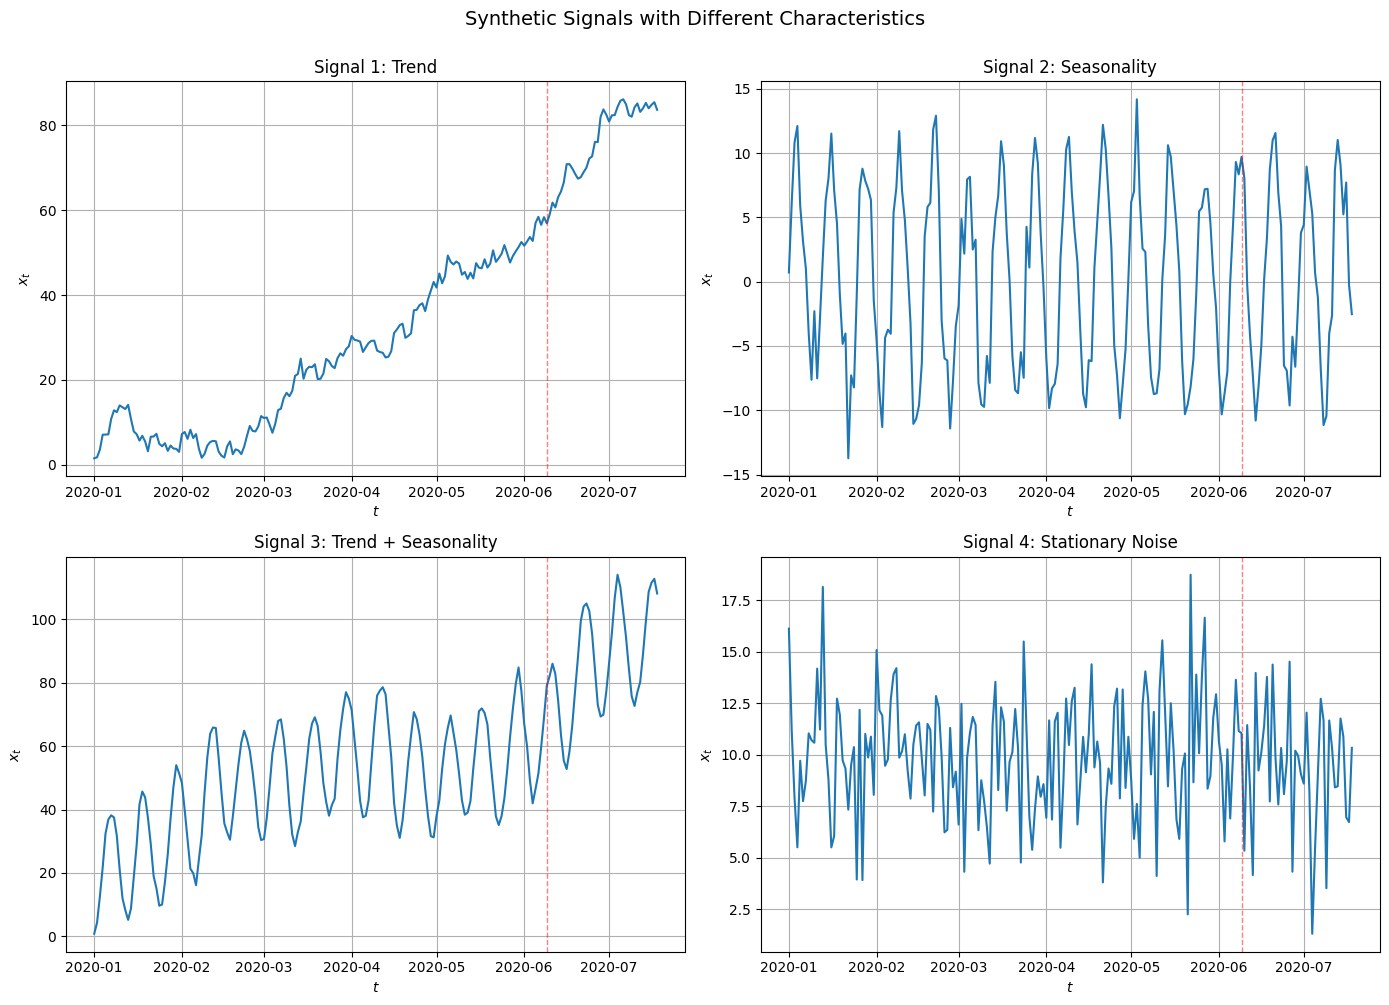

In [3]:
fig, axs = get_figure(nrows=2, ncols=2, figsize=(14, 10))
signals = {
    "Signal 1: Trend": signal1,
    "Signal 2: Seasonality": signal2,
    "Signal 3: Trend + Seasonality": signal3,
    "Signal 4: Stationary Noise": signal4
}

for ax, (title, signal) in zip(axs, signals.items()):
    time_plot(x=signal.index, y=signal, title=title, ax=ax)
    ax.axvline(x=signal.index[train_size], color='red', linestyle='--', linewidth=1, alpha=0.5)
    
fig.suptitle("Synthetic Signals with Different Characteristics", fontsize=14, y=1.00)
fig.tight_layout()

### Fit Different ETS Models

To get an idea, even ETS models that don't suit the data particularily well have been chosen.

In [4]:
def compare_ets_models(signal, signal_name, train_size, ets_configs: dict):
    """Compare different ETS configurations on a signal"""
       
    results = []    
    for name, model in ets_configs.items():
        try:
            fitted_values, predictions, pred_interval = fit_and_forecast(model, signal, train_size)
            
            test_data = signal.iloc[train_size:]
            mse = mean_squared_error(test_data, predictions)
            mae = mean_absolute_error(test_data, predictions)
            
            # Get fitted parameters
            if hasattr(model, '_fitted_forecaster'):
                alpha = getattr(model._fitted_forecaster, 'smoothing_level', None)
                beta = getattr(model._fitted_forecaster, 'smoothing_trend', None)
                gamma = getattr(model._fitted_forecaster, 'smoothing_seasonal', None)
                phi = getattr(model._fitted_forecaster, 'damping_trend', None)
            else:
                alpha = beta = gamma = phi = None
            
            results.append({
                'Signal': signal_name,
                'Model': name,
                'MSE': mse,
                'MAE': mae,
                'α': alpha,
                'β*': beta,
                'γ': gamma,
                'φ': phi,
                'fitted': fitted_values,
                'predictions': predictions,
                'interval': pred_interval
            })
        except Exception as e:
            print(f"Error fitting {name}: {e}")
            continue
    
    return results

In [5]:

ets_configs = {
    'ETS(A,N,N)': AutoETS(error='add', trend=None, seasonal=None, auto=False),
    'ETS(A,A,N)': AutoETS(error='add', trend='add', seasonal=None, auto=False),
    'ETS(A,Ad,N)': AutoETS(error='add', trend='add', damped_trend=True, seasonal=None, auto=False),
    'ETS(A,N,A)': AutoETS(error='add', trend=None, seasonal='add', sp=period, auto=False),
    'ETS(A,A,A)': AutoETS(error='add', trend='add', seasonal='add', sp=period, auto=False),
}

In [6]:
print("Comparing ETS Models on Different Synthetic Signals")
print("=" * 80)

all_results = {}
for i, (name, signal) in enumerate(signals.items()):
    results = compare_ets_models(signal, name, train_size, ets_configs=ets_configs)
    all_results[name] = results
    
    df_results = pd.DataFrame([{k: v for k, v in r.items() if k not in ['fitted', 'predictions', 'interval']} 
                                for r in results])
    print(f"\n{name}")
    print("-" * 80)
    print(df_results.to_string(index=False))

Comparing ETS Models on Different Synthetic Signals

Signal 1: Trend
--------------------------------------------------------------------------------
         Signal       Model        MSE       MAE        α       β*        γ        φ
Signal 1: Trend  ETS(A,N,N) 397.769319 17.894267 0.946584      NaN      NaN      NaN
Signal 1: Trend  ETS(A,A,N) 139.868948 10.628301 0.898590 0.000090      NaN      NaN
Signal 1: Trend ETS(A,Ad,N) 372.772286 17.259450 0.882157 0.032925      NaN 0.846354
Signal 1: Trend  ETS(A,N,A) 368.117919 17.054267 0.999900      NaN 0.000024      NaN
Signal 1: Trend  ETS(A,A,A) 119.242802  9.710306 0.887857 0.000089 0.000011      NaN

Signal 1: Trend
--------------------------------------------------------------------------------
         Signal       Model        MSE       MAE        α       β*        γ        φ
Signal 1: Trend  ETS(A,N,N) 397.769319 17.894267 0.946584      NaN      NaN      NaN
Signal 1: Trend  ETS(A,A,N) 139.868948 10.628301 0.898590 0.000090      

In [7]:
def plot_forecasts(signal, signal_name, results):
    fig, axs = get_figure(nrows=2, ncols=3, figsize=(16, 10), sharey=True)

    for i, result in enumerate(results):
        if i < len(axs):
            ax = axs[i]
            time_plot(x=signal.index, y=signal, label='Actual', ax=ax, alpha=0.7)
            ax.axvline(x=signal.index[train_size], color='red', linestyle='--', linewidth=1, alpha=0.5)
            plot_fit_and_forecast(ax, result['fitted'], result['predictions'], 
                                result['interval'], model_name=result['Model'])
            ax.set_title(f"{result['Model']} | MSE={result['MSE']:.2f}")
            ax.legend(fontsize=8)

    if len(results) < len(axs):
        axs[-1].axis('off')

    fig.suptitle(f"{signal_name}: ETS Model Comparison", fontsize=14)
    fig.tight_layout()

The next cell shows the predictions of all the ets models for the first signal.

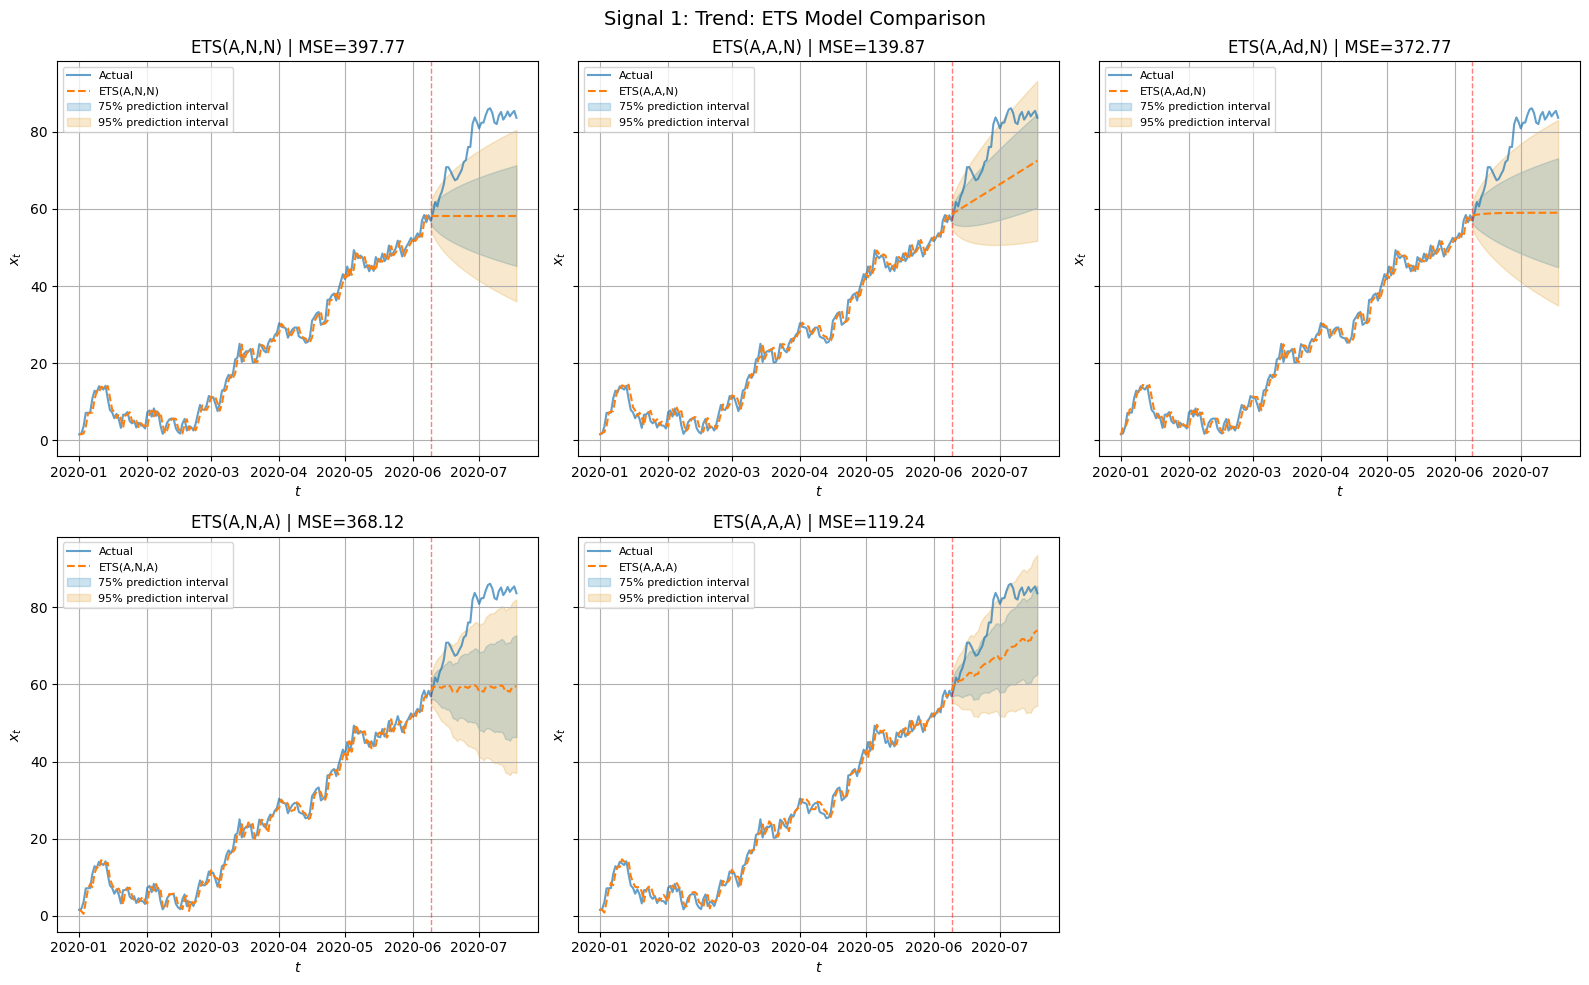

In [8]:
signal = list(signals.items())[0]
plot_forecasts(signal=signal[1],signal_name=signal[0], results=all_results[signal[0]])

The predictions on signal 2:

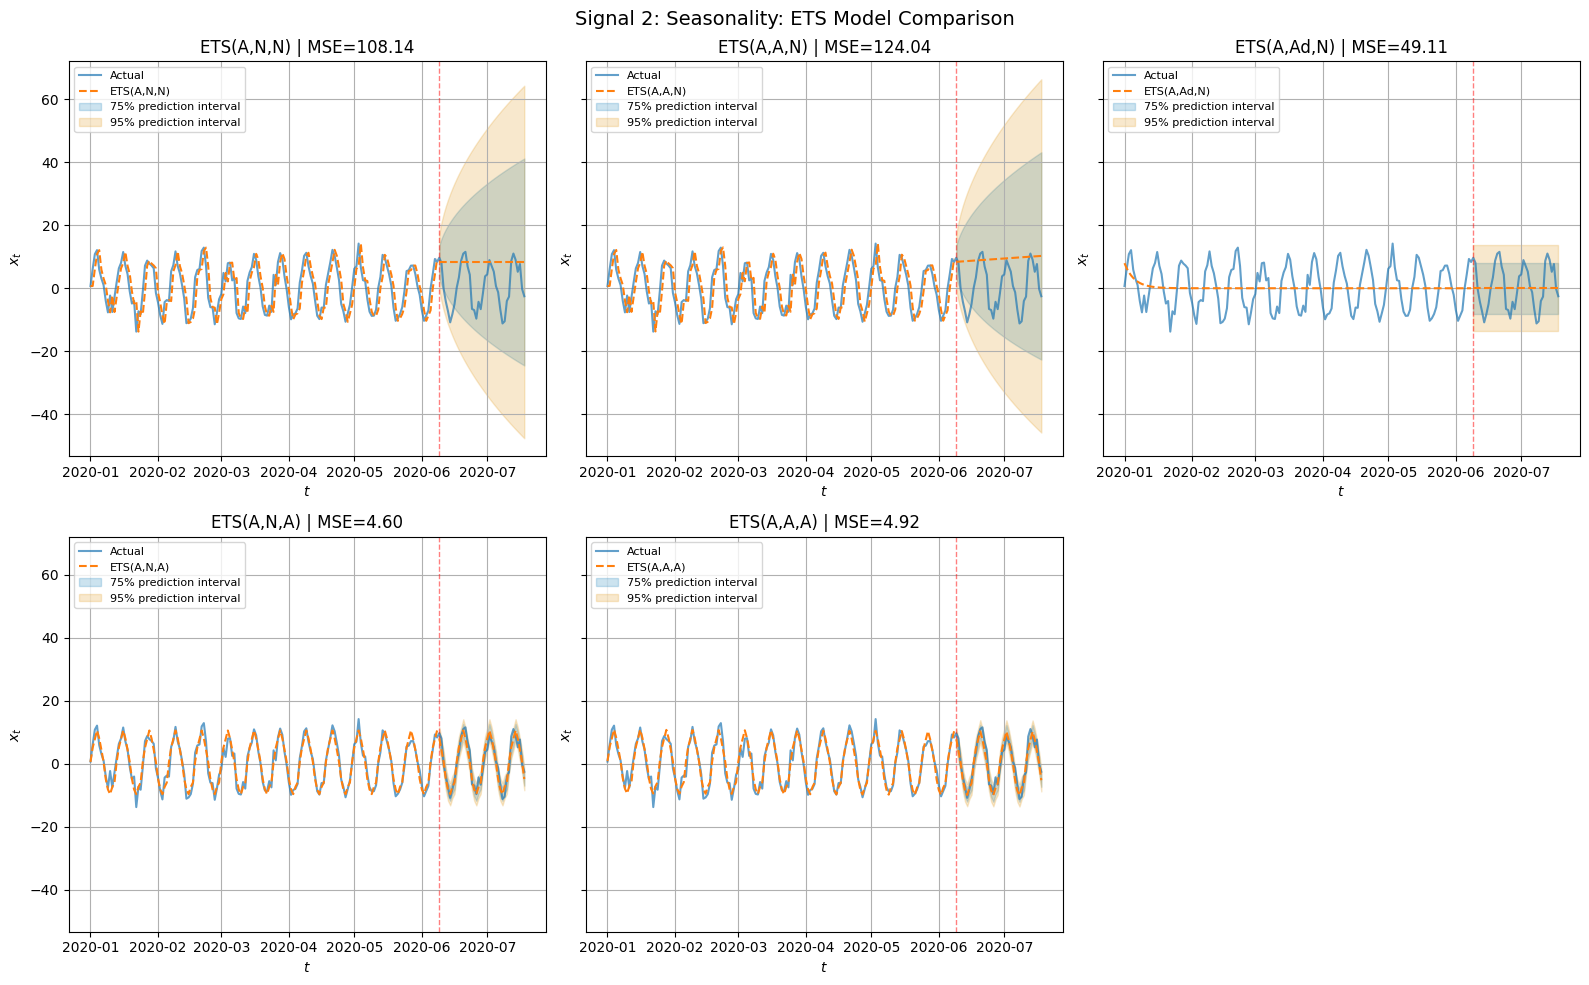

In [9]:
signal = list(signals.items())[1]
plot_forecasts(signal=signal[1],signal_name=signal[0], results=all_results[signal[0]])

The predictions on signal 3:

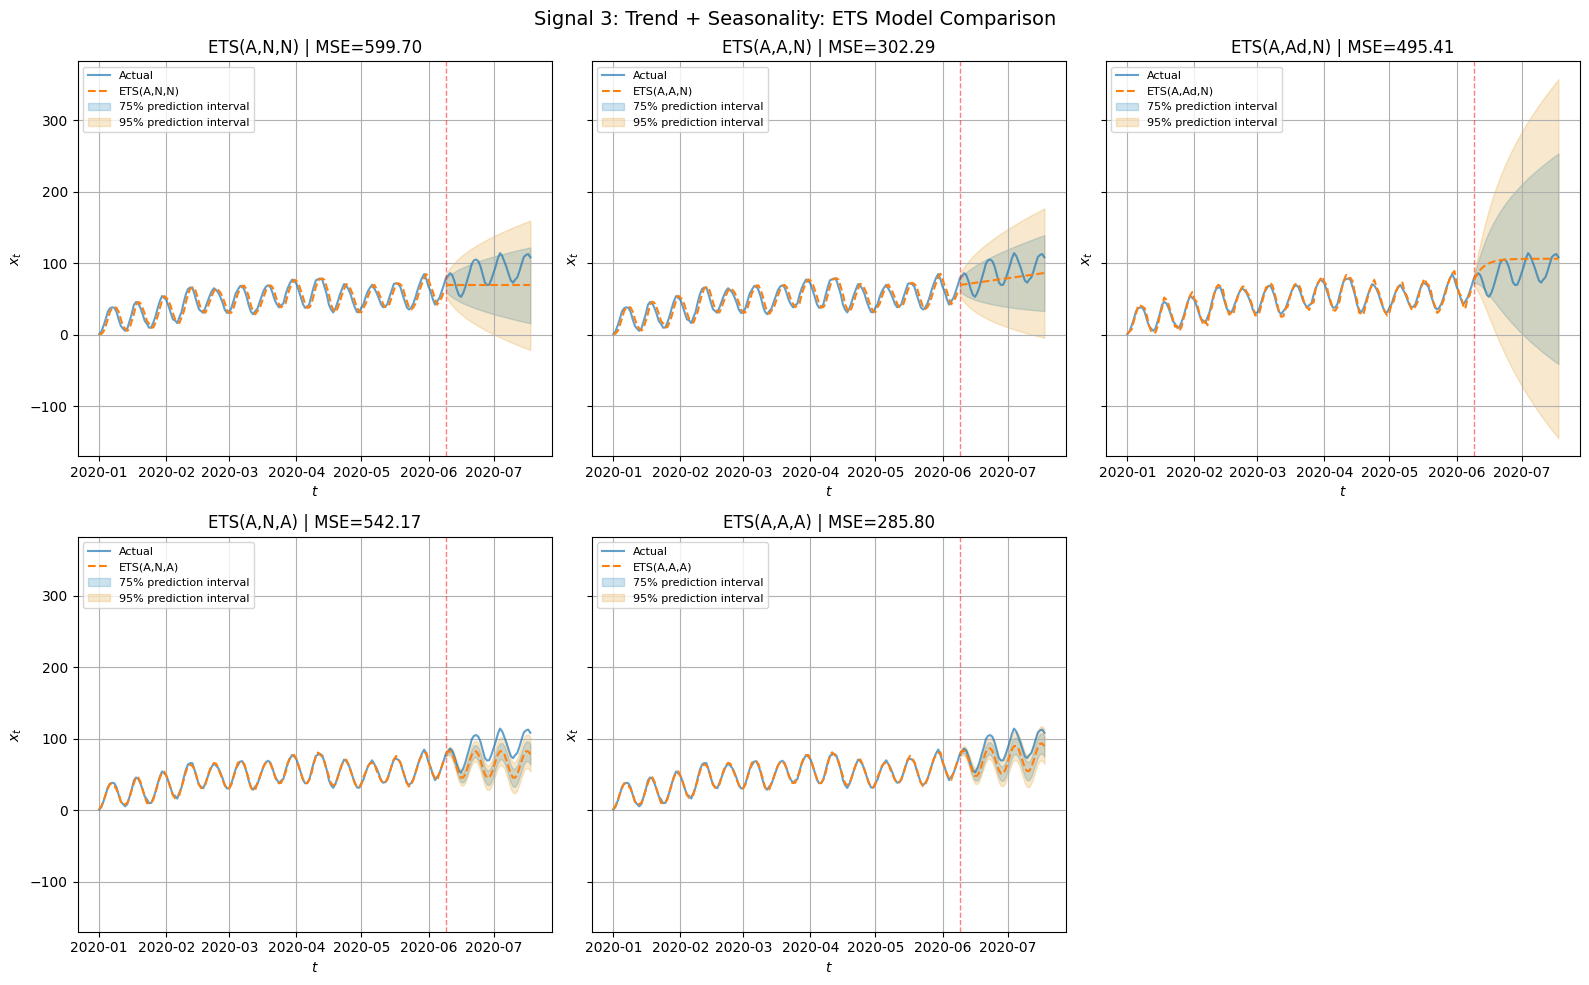

In [10]:
signal = list(signals.items())[2]
plot_forecasts(signal=signal[1],signal_name=signal[0], results=all_results[signal[0]])

The predictions on signal 4:

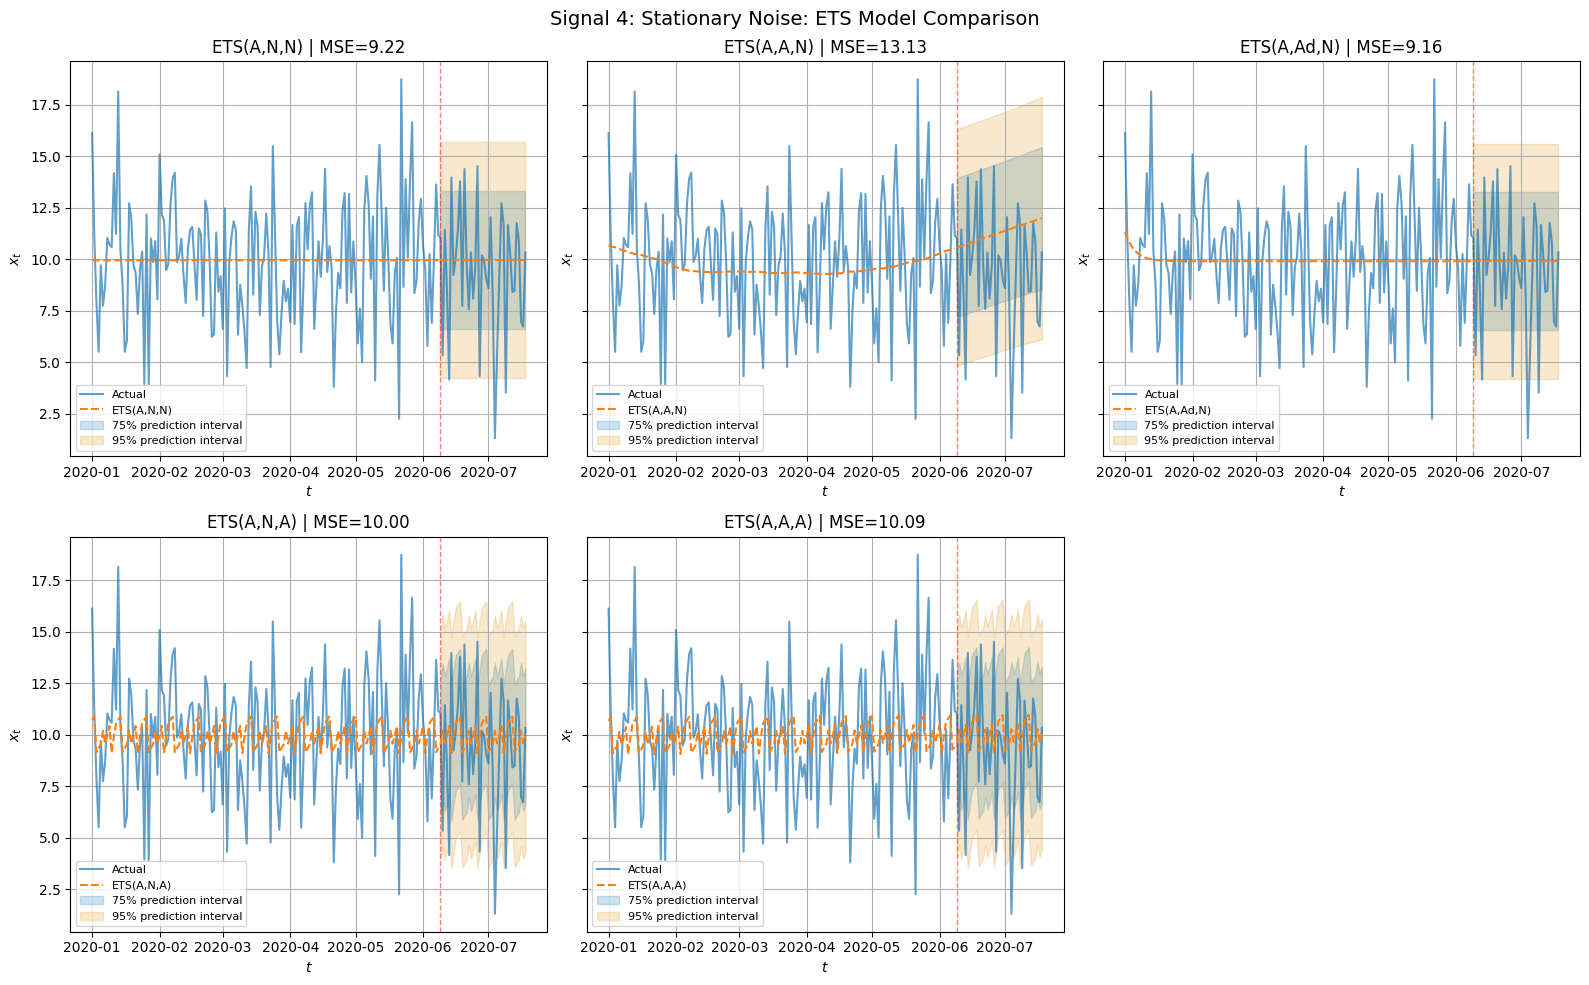

In [11]:
signal = list(signals.items())[3]
plot_forecasts(signal=signal[1],signal_name=signal[0], results=all_results[signal[0]])

### Equivalence with ARIMA models

The models tested:

In [12]:
ets_configs

{'ETS(A,N,N)': AutoETS(),
 'ETS(A,A,N)': AutoETS(trend='add'),
 'ETS(A,Ad,N)': AutoETS(damped_trend=True, trend='add'),
 'ETS(A,N,A)': AutoETS(seasonal='add', sp=12),
 'ETS(A,A,A)': AutoETS(seasonal='add', sp=12, trend='add')}

The arima equivalences would be:
- $ETS(A, N, N)$ --> $ARIMA(0, 1, 1)$
- $ETS(A, A, N)$ --> $ARIMA(0, 2, 2)$
- $ETS(A, Ad, N)$ --> $ARIMA(1, 1, 2)$
- $ETS(A, N, A)$ --> $ARIMA(0, 1, P)(0, 1, 0)_P$
- $ETS(A, A, A)$ --> $ARIMA(0, 1, P + 1)(0, 1, 0)_P$

In [13]:
arima_configs = {
    'ARIMA(0,1,1)': ARIMA(order=(0,1,1), suppress_warnings=True),
    'ARIMA(0,2,2)': ARIMA(order=(0,2,2), suppress_warnings=True),
    'ARIMA(1,1,2)': ARIMA(order=(1,1,2), suppress_warnings=True),
    'ARIMA(0,1,P)(0,1,0)[P]': ARIMA(order=(0,1,period), seasonal_order=(0,1,0,period), suppress_warnings=True),
    'ARIMA(0,1,P+1)(0,1,0)[P]': ARIMA(order=(0,1,period+1), seasonal_order=(0,1,0,period), suppress_warnings=True),
}
arima_configs


{'ARIMA(0,1,1)': ARIMA(order=(0, 1, 1), suppress_warnings=True),
 'ARIMA(0,2,2)': ARIMA(order=(0, 2, 2), suppress_warnings=True),
 'ARIMA(1,1,2)': ARIMA(order=(1, 1, 2), suppress_warnings=True),
 'ARIMA(0,1,P)(0,1,0)[P]': ARIMA(order=(0, 1, 12), seasonal_order=(0, 1, 0, 12), suppress_warnings=True),
 'ARIMA(0,1,P+1)(0,1,0)[P]': ARIMA(order=(0, 1, 13), seasonal_order=(0, 1, 0, 12), suppress_warnings=True)}

Giving the following equivalences:

In [14]:
ets_arima_eq = (
    ('ETS(A,N,N)', 'ARIMA(0,1,1)'),
    ('ETS(A,A,N)', 'ARIMA(0,2,2)'),
    ('ETS(A,Ad,N)', 'ARIMA(1,1,2)'),
    ('ETS(A,N,A)', 'ARIMA(0,1,P)(0,1,0)[P]'),
    ('ETS(A,A,A)', 'ARIMA(0,1,P+1)(0,1,0)[P]')
)

In [15]:

def compare_ets_arima(signal, equivalences, ets_configs, arima_configs):
    fig, axs = get_figure(nrows=3, ncols=2, figsize=(16, 12), sharey=True)

    comparison_results = []

    for i, (ets_name, arima_name) in enumerate(equivalences):
        ax = axs[i]

        ets_model = ets_configs[ets_name]
        arima_model = arima_configs[arima_name]
    
        ets_fit, ets_pred, ets_interval = fit_and_forecast(ets_model, signal, train_size)
        ets_mse = mean_squared_error(signal.iloc[train_size:], ets_pred)
    
        arima_fit, arima_pred, arima_interval = fit_and_forecast(arima_model, signal, train_size)
        arima_mse = mean_squared_error(signal.iloc[train_size:], arima_pred)
    
        time_plot(x=signal.index, y=signal, label='Actual', ax=ax, alpha=0.5)
        ax.axvline(x=signal.index[train_size], color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
        plot_fit_and_forecast(ax, ets_fit, ets_pred, None, model_name=f'{ets_name}')
        plot_fit_and_forecast(ax, arima_fit, arima_pred, None, model_name=f'{arima_name}')
    
        ax.set_title(f'{ets_name} vs {arima_name}')
        ax.legend(fontsize=8)
    
        comparison_results.append({
        'ETS Model': ets_name,
        'ETS MSE': ets_mse,
        'ARIMA Model': arima_name,
        'ARIMA MSE': arima_mse,
        'MSE Diff': abs(ets_mse - arima_mse)
    })
        
    if len(equivalences) < len(axs):
        axs[-1].axis('off')

    fig.suptitle("ETS and ARIMA Equivalence Verification", fontsize=14)
    fig.tight_layout()
    return pd.DataFrame(comparison_results)

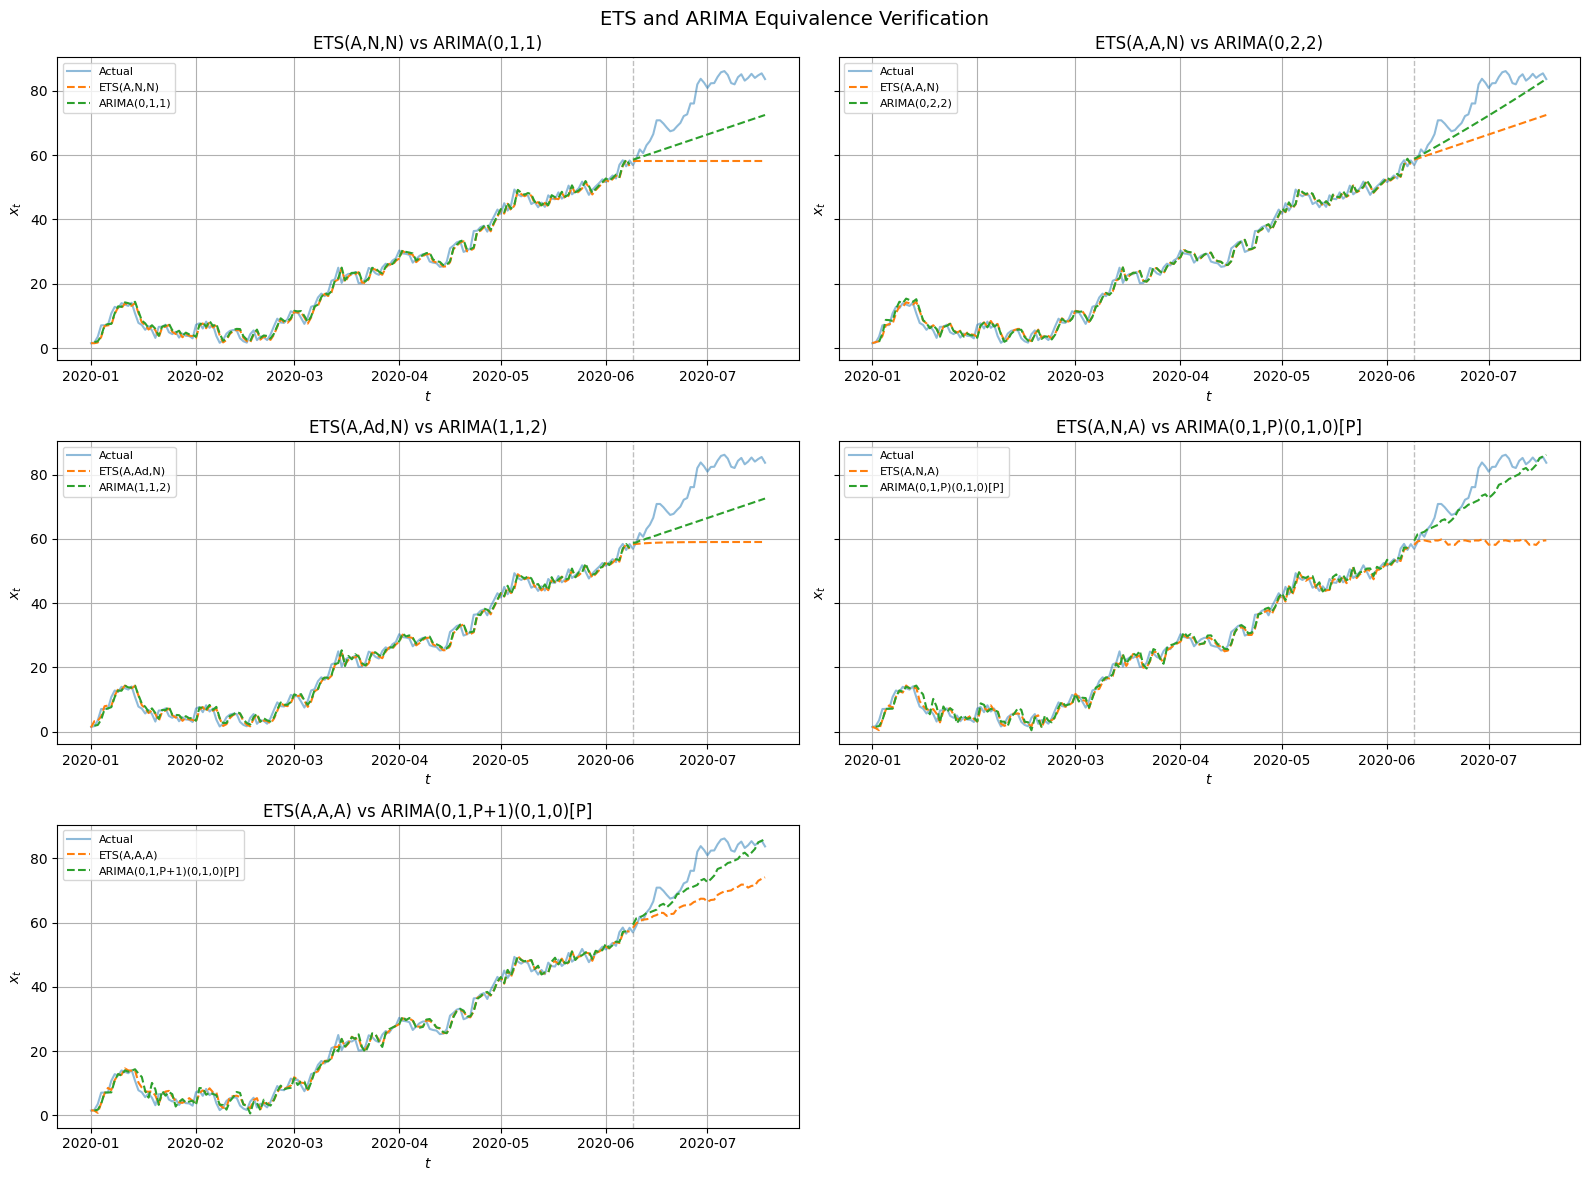

In [16]:
comparison_results = compare_ets_arima(list(signals.items())[0][1], ets_arima_eq, ets_configs, arima_configs)

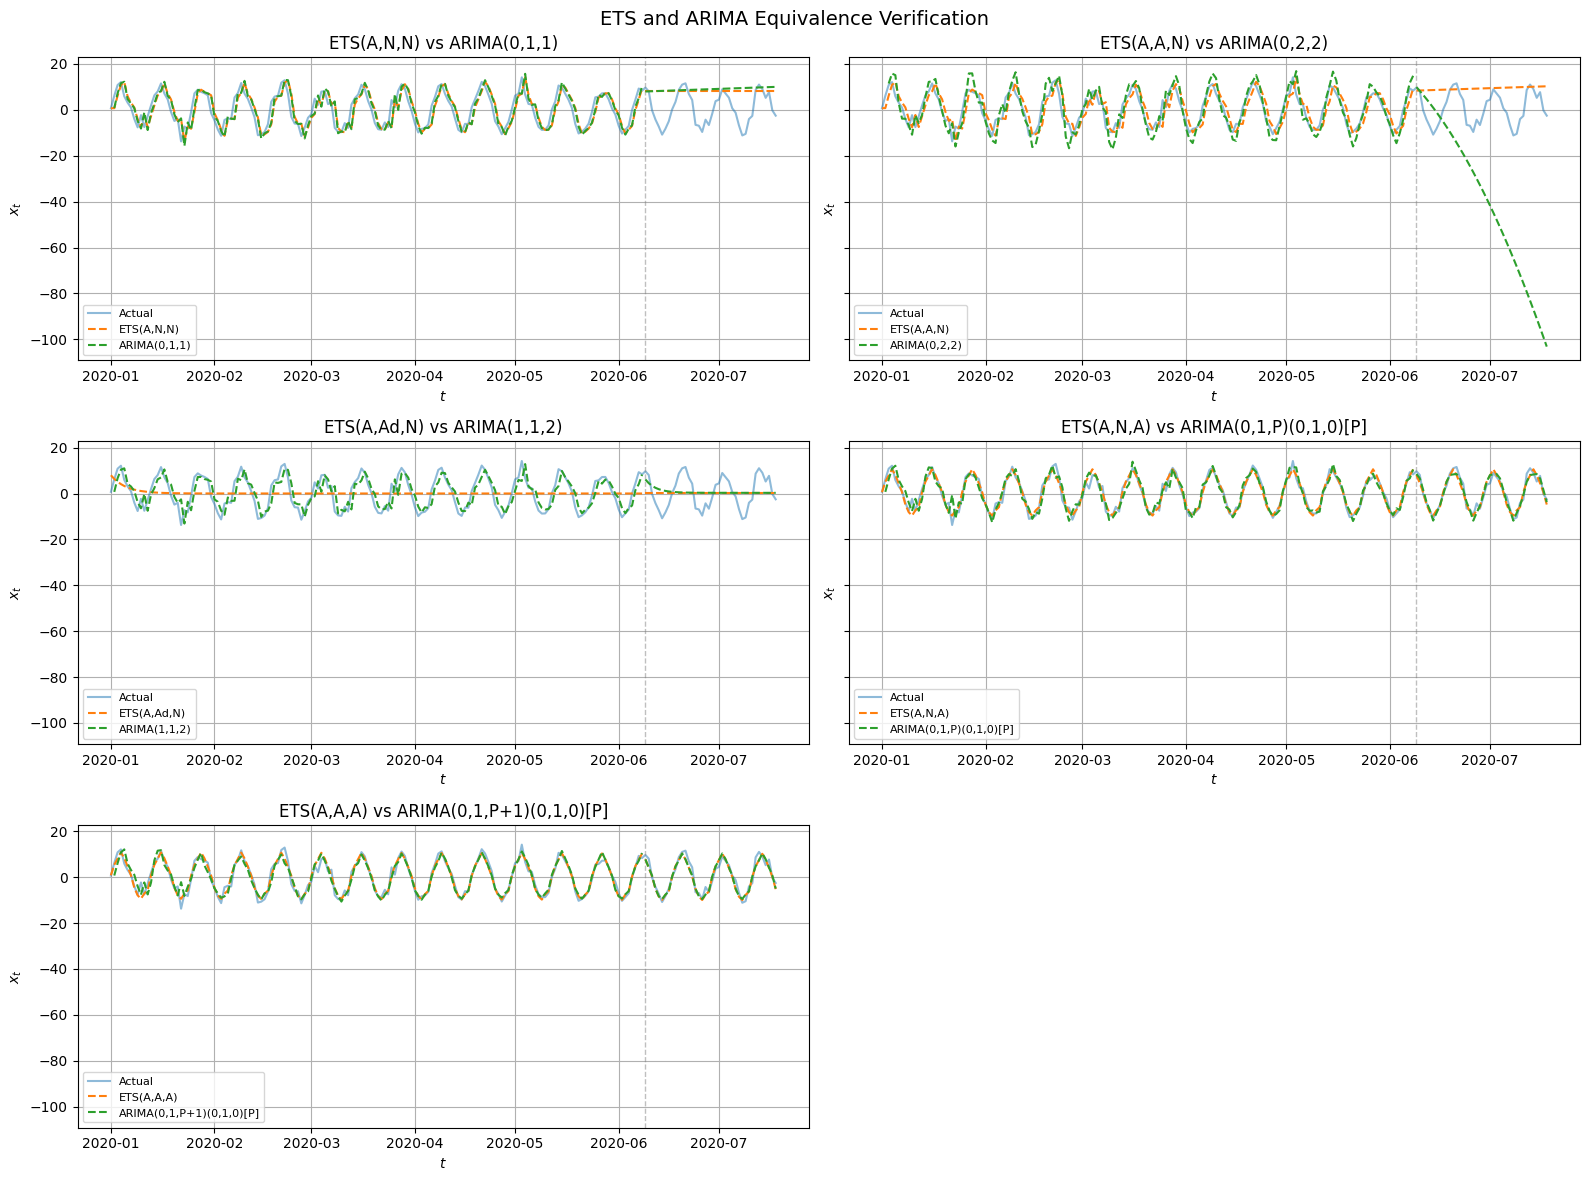

In [17]:
comparison_results = compare_ets_arima(list(signals.items())[1][1], ets_arima_eq, ets_configs, arima_configs)

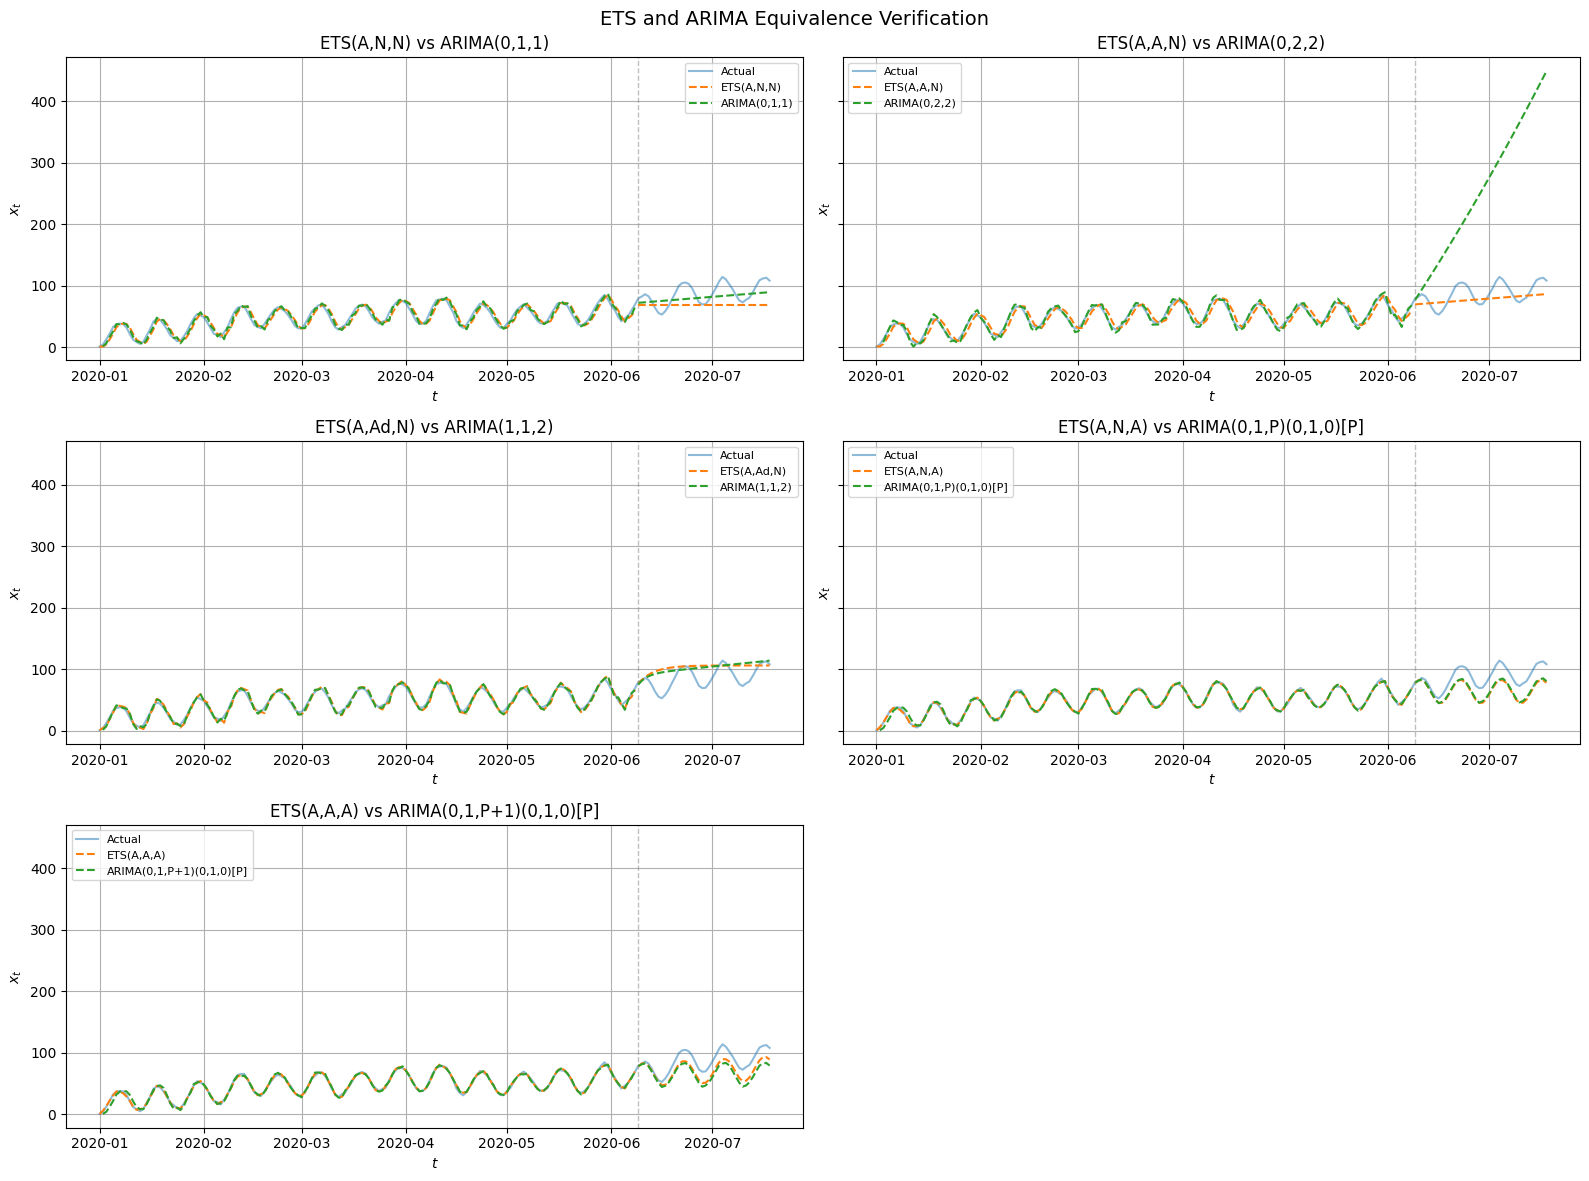

In [18]:
comparison_results = compare_ets_arima(list(signals.items())[2][1], ets_arima_eq, ets_configs, arima_configs)

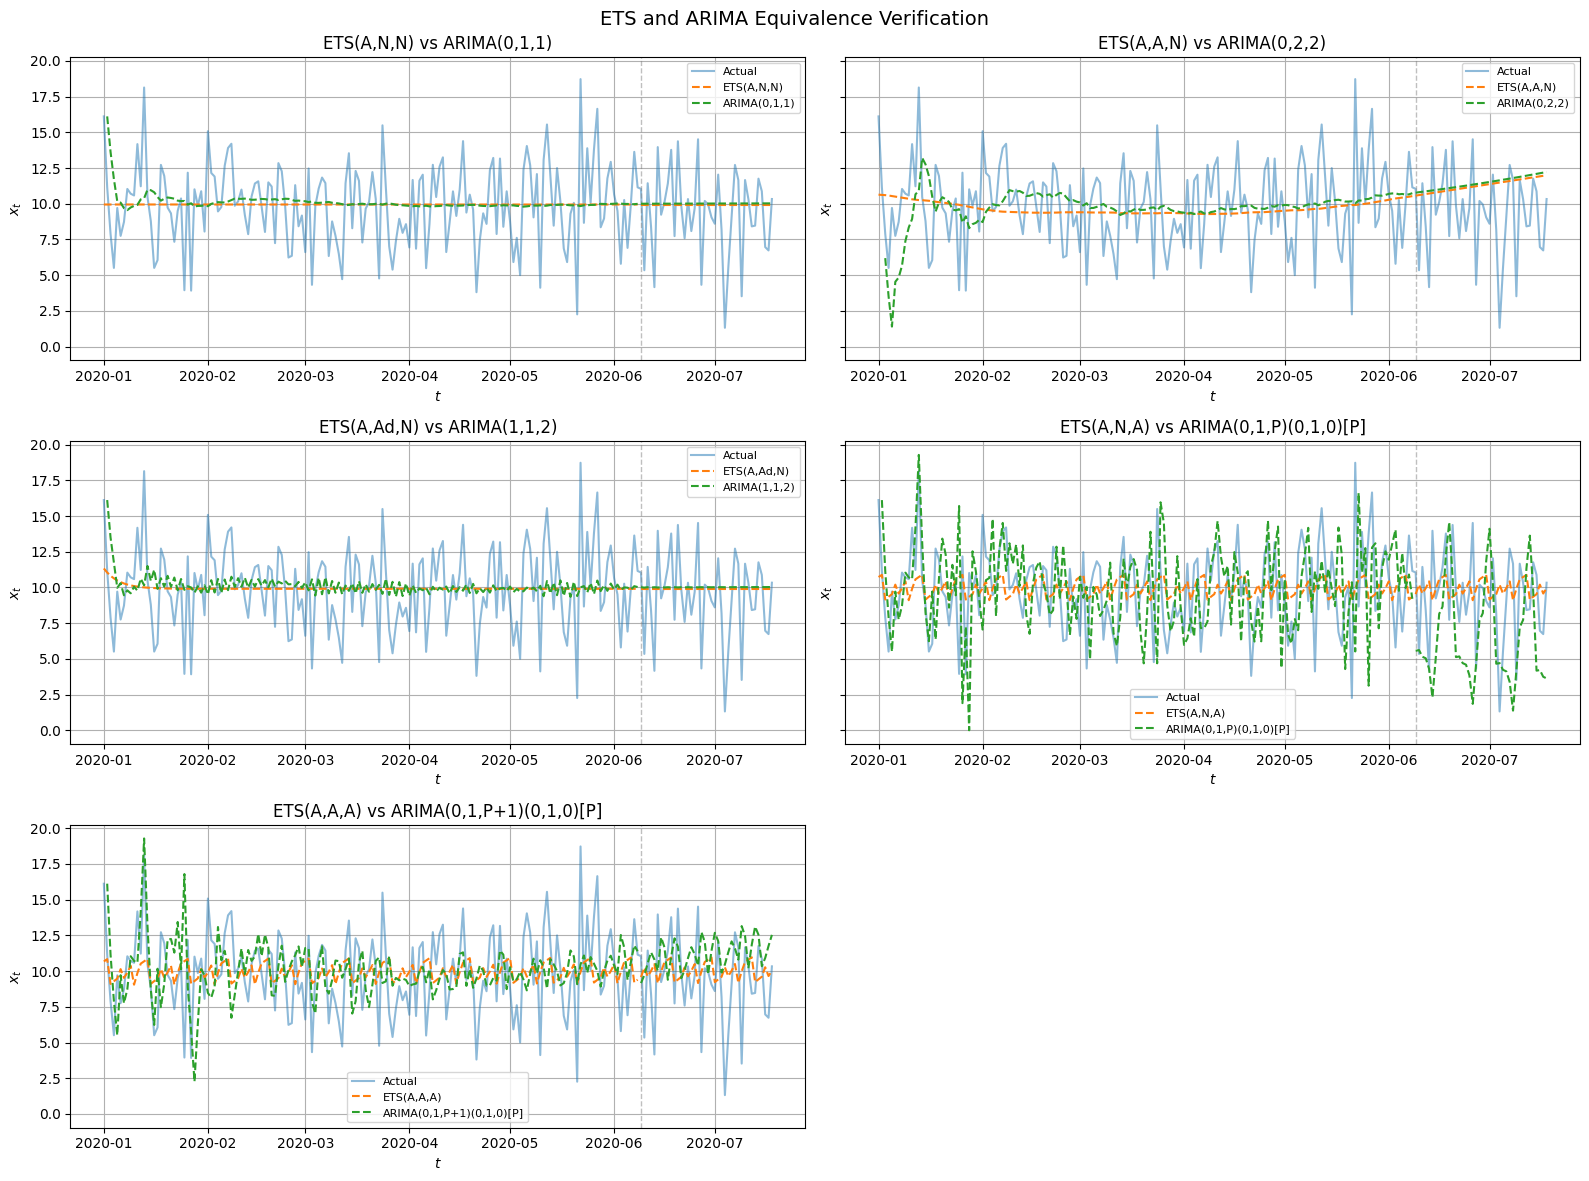

In [19]:
comparison_results = compare_ets_arima(list(signals.items())[3][1], ets_arima_eq, ets_configs, arima_configs)

Even though the respective ETS and ARIMA models are theoretically equivalent, the very different results especially when forecasting. However, for the training data the results of the two models respectively are very similar, but only if the model is suited for the data. E.g. with the stationary noise, the equivalent models show a very different fit, except for the ETS(A,N, N) and ARIMA(0,1,1) models.

### Estimate Parameters from Generated Data

Now we'll test all ETS model configurations on each synthetic signal to:
1. Compare how different models perform on each signal type
2. Verify parameter recovery against known true values
3. Identify the best model for each signal based on AIC/BIC

**True Parameters:**
- Signal 1: Drift = 0.5
- Signal 2: Amplitude = 10  
- Signal 3: Drift = 0.3, Amplitude = 10
- Signal 4: White noise (no specific parameters)

In [20]:
def estimate_ets_parameters(signal, model, true_params=None):
    """
    Estimate parameters from an ETS model fitted to a signal.
    
    Parameters:
    -----------
    signal : pd.Series
        Time series data
    model : AutoETS
        ETS model instance (not yet fitted)
    true_params : dict, optional
        Dictionary of true parameters for comparison (e.g., {'drift': 0.3, 'amplitude': 10})
    
    Returns:
    --------
    dict : Dictionary containing estimated parameters
    """
    model.fit(signal)
    
    results = {
        'model_spec': str(model),
    }
    
    # Extract smoothing parameters
    if hasattr(model._fitted_forecaster, 'smoothing_level'):
        results['alpha (level)'] = model._fitted_forecaster.smoothing_level
    
    if hasattr(model._fitted_forecaster, 'smoothing_trend'):
        results['beta (trend)'] = model._fitted_forecaster.smoothing_trend
    
    if hasattr(model._fitted_forecaster, 'smoothing_seasonal'):
        results['gamma (seasonal)'] = model._fitted_forecaster.smoothing_seasonal
    
    if hasattr(model._fitted_forecaster, 'damping_trend'):
        results['phi (damping)'] = model._fitted_forecaster.damping_trend
    
    # Extract and estimate drift from trend component
    if hasattr(model._fitted_forecaster, 'trend'):
        trend = model._fitted_forecaster.trend
        # Check if trend is array-like with multiple values
        try:
            if hasattr(trend, '__len__') and len(trend) > 1:
                trend_array = np.array(trend)
                if trend_array.ndim > 0:
                    estimated_drift = np.mean(np.diff(trend_array))
                    results['estimated_drift'] = estimated_drift
                    
                    if true_params and 'drift' in true_params:
                        results['true_drift'] = true_params['drift']
                        results['drift_error'] = abs(estimated_drift - true_params['drift'])
        except (ValueError, TypeError):
            pass  # Skip if trend is not suitable for diff
    
    # Extract and estimate amplitude from seasonal component
    if hasattr(model._fitted_forecaster, 'season'):
        season = model._fitted_forecaster.season
        estimated_amplitude = (season.max() - season.min()) / 2
        results['estimated_amplitude'] = estimated_amplitude
        
        if true_params and 'amplitude' in true_params:
            results['true_amplitude'] = true_params['amplitude']
            results['amplitude_error'] = abs(estimated_amplitude - true_params['amplitude'])
    
    # Extract level (initial state)
    if hasattr(model._fitted_forecaster, 'level'):
        level = model._fitted_forecaster.level
        if hasattr(level, '__len__'):
            results['initial_level'] = level.iloc[0] if hasattr(level, 'iloc') else level[0]
        else:
            results['initial_level'] = level
    
    # Model fit statistics
    if hasattr(model._fitted_forecaster, 'aic'):
        results['AIC'] = model._fitted_forecaster.aic
    if hasattr(model._fitted_forecaster, 'bic'):
        results['BIC'] = model._fitted_forecaster.bic
    
    return results


def print_parameter_estimates(results, signal_name):
    """
    Pretty print parameter estimation results.
    
    Parameters:
    -----------
    results : dict
        Results from estimate_ets_parameters
    signal_name : str
        Name of the signal for display
    """
    print("=" * 80)
    print(f"Parameter Estimation: {signal_name}")
    print("=" * 80)
    print(f"Model: {results.get('model_spec', 'N/A')}")
    print()
    
    # Smoothing parameters
    print("Smoothing Parameters:")
    if 'alpha (level)' in results:
        print(f"  α (level):     {results['alpha (level)']:.4f}")
    if 'beta (trend)' in results:
        print(f"  β* (trend):    {results['beta (trend)']:.4f}")
    if 'gamma (seasonal)' in results:
        print(f"  γ (seasonal):  {results['gamma (seasonal)']:.4f}")
    if 'phi (damping)' in results:
        print(f"  φ (damping):   {results['phi (damping)']:.4f}")
    print()
    
    # Estimated vs True parameters
    if 'estimated_drift' in results:
        print("Drift Parameter:")
        print(f"  Estimated: {results['estimated_drift']:.4f}")
        if 'true_drift' in results:
            print(f"  True:      {results['true_drift']:.4f}")
            print(f"  Error:     {results['drift_error']:.4f}")
        print()
    
    if 'estimated_amplitude' in results:
        print("Amplitude Parameter:")
        print(f"  Estimated: {results['estimated_amplitude']:.2f}")
        if 'true_amplitude' in results:
            print(f"  True:      {results['true_amplitude']:.2f}")
            print(f"  Error:     {results['amplitude_error']:.2f}")
        print()
    
    if 'initial_level' in results:
        print(f"Initial Level: {results['initial_level']:.2f}")
        print()
    
    # Model fit
    if 'AIC' in results or 'BIC' in results:
        print("Model Fit:")
        if 'AIC' in results:
            print(f"  AIC: {results['AIC']:.2f}")
        if 'BIC' in results:
            print(f"  BIC: {results['BIC']:.2f}")
    
    print("=" * 80)
    print()

In [21]:
# Signal 1: Trend only
# Test all ETS models on Signal 1
signal_name, signal = list(signals.items())[0]
print(f"\n{'='*80}")
print(f"Testing all ETS models on {signal_name}")
print(f"{'='*80}\n")

for name, ets_model in ets_configs.items():
    results = estimate_ets_parameters(
        signal, 
        ets_model,
        true_params={'drift': drift_level}  # True drift = 0.5
    )
    print_parameter_estimates(results, f"{signal_name} | Model: {name}")


Testing all ETS models on Signal 1: Trend

Parameter Estimation: Signal 1: Trend | Model: ETS(A,N,N)
Model: AutoETS()

Smoothing Parameters:
  α (level):     0.9992

Initial Level: 1.49

Model Fit:
  AIC: 830.52
  BIC: 840.42

Parameter Estimation: Signal 1: Trend | Model: ETS(A,A,N)
Model: AutoETS(trend='add')

Smoothing Parameters:
  α (level):     0.9433
  β* (trend):    0.0001

Initial Level: 1.49

Model Fit:
  AIC: 824.34
  BIC: 840.83

Parameter Estimation: Signal 1: Trend | Model: ETS(A,Ad,N)
Model: AutoETS(damped_trend=True, trend='add')

Smoothing Parameters:
  α (level):     0.9389
  β* (trend):    0.0253
  φ (damping):   0.9800

Initial Level: 1.49

Model Fit:
  AIC: 830.44
  BIC: 850.23

Parameter Estimation: Signal 1: Trend | Model: ETS(A,N,A)
Model: AutoETS(seasonal='add', sp=12)

Smoothing Parameters:
  α (level):     0.9819
  γ (seasonal):  0.0000

Amplitude Parameter:
  Estimated: 1.14

Initial Level: 1.49

Model Fit:
  AIC: 835.27
  BIC: 888.05

Parameter Estimation:

In [22]:
# Signal 2: Seasonality only
# Test all ETS models on Signal 2
signal_name, signal = list(signals.items())[1]
print(f"\n{'='*80}")
print(f"Testing all ETS models on {signal_name}")
print(f"{'='*80}\n")

for name, ets_model in ets_configs.items():
    results = estimate_ets_parameters(
        signal, 
        ets_model,
        true_params={'amplitude': amplitude}
    )
    print_parameter_estimates(results, f"{signal_name} | Model: {name}")


Testing all ETS models on Signal 2: Seasonality

Parameter Estimation: Signal 2: Seasonality | Model: ETS(A,N,N)
Model: AutoETS()

Smoothing Parameters:
  α (level):     0.9999

Initial Level: 0.72

Model Fit:
  AIC: 1176.07
  BIC: 1185.96

Parameter Estimation: Signal 2: Seasonality | Model: ETS(A,A,N)
Model: AutoETS(trend='add')

Smoothing Parameters:
  α (level):     0.9999
  β* (trend):    0.0001

Initial Level: 0.72

Model Fit:
  AIC: 1180.09
  BIC: 1196.58

Parameter Estimation: Signal 2: Seasonality | Model: ETS(A,Ad,N)
Model: AutoETS(damped_trend=True, trend='add')

Smoothing Parameters:
  α (level):     0.0001
  β* (trend):    0.0000
  φ (damping):   0.8123

Initial Level: 6.98

Model Fit:
  AIC: 1357.45
  BIC: 1377.24

Parameter Estimation: Signal 2: Seasonality | Model: ETS(A,N,A)
Model: AutoETS(seasonal='add', sp=12)

Smoothing Parameters:
  α (level):     0.0001
  γ (seasonal):  0.0001

Amplitude Parameter:
  Estimated: 10.10
  True:      10.00
  Error:     0.10

Initial 

In [23]:
# Signal 3: Trend + Seasonality
# Test all ETS models on Signal 3
signal_name, signal = list(signals.items())[2]
print(f"\n{'='*80}")
print(f"Testing all ETS models on {signal_name}")
print(f"{'='*80}\n")

for name, ets_model in ets_configs.items():
    results = estimate_ets_parameters(
        signal, 
        ets_model,
        true_params={'drift': 0.3, 'amplitude': amplitude}  # True drift = 0.3, amplitude = 10
    )
    print_parameter_estimates(results, f"{signal_name} | Model: {name}")


Testing all ETS models on Signal 3: Trend + Seasonality

Parameter Estimation: Signal 3: Trend + Seasonality | Model: ETS(A,N,N)
Model: AutoETS()

Smoothing Parameters:
  α (level):     0.9999

Initial Level: 0.81

Model Fit:
  AIC: 1371.15
  BIC: 1381.04

Parameter Estimation: Signal 3: Trend + Seasonality | Model: ETS(A,A,N)
Model: AutoETS(trend='add')

Smoothing Parameters:
  α (level):     0.9999
  β* (trend):    0.0001

Initial Level: 0.81

Model Fit:
  AIC: 1374.09
  BIC: 1390.58

Parameter Estimation: Signal 3: Trend + Seasonality | Model: ETS(A,Ad,N)
Model: AutoETS(damped_trend=True, trend='add')

Smoothing Parameters:
  α (level):     0.9999
  β* (trend):    0.9998
  φ (damping):   0.8006

Initial Level: 0.81

Model Fit:
  AIC: 1172.37
  BIC: 1192.16

Parameter Estimation: Signal 3: Trend + Seasonality | Model: ETS(A,N,A)
Model: AutoETS(seasonal='add', sp=12)

Smoothing Parameters:
  α (level):     0.9999
  γ (seasonal):  0.0000

Amplitude Parameter:
  Estimated: 18.68
  True

In [24]:
# Signal 4: Stationary noise
# Test all ETS models on Signal 4
signal_name, signal = list(signals.items())[3]
print(f"\n{'='*80}")
print(f"Testing all ETS models on {signal_name}")
print(f"{'='*80}\n")

for name, ets_model in ets_configs.items():
    results = estimate_ets_parameters(
        signal, 
        ets_model,
        true_params=None  # No specific parameters for white noise
    )
    print_parameter_estimates(results, f"{signal_name} | Model: {name}")


Testing all ETS models on Signal 4: Stationary Noise

Parameter Estimation: Signal 4: Stationary Noise | Model: ETS(A,N,N)
Model: AutoETS()

Smoothing Parameters:
  α (level):     0.0001

Initial Level: 9.82

Model Fit:
  AIC: 1004.75
  BIC: 1014.65

Parameter Estimation: Signal 4: Stationary Noise | Model: ETS(A,A,N)
Model: AutoETS(trend='add')

Smoothing Parameters:
  α (level):     0.0001
  β* (trend):    0.0000

Initial Level: 10.11

Model Fit:
  AIC: 1008.10
  BIC: 1024.59

Parameter Estimation: Signal 4: Stationary Noise | Model: ETS(A,Ad,N)
Model: AutoETS(damped_trend=True, trend='add')

Smoothing Parameters:
  α (level):     0.0001
  β* (trend):    0.0000
  φ (damping):   0.9639

Initial Level: 10.53

Model Fit:
  AIC: 1009.95
  BIC: 1029.74

Parameter Estimation: Signal 4: Stationary Noise | Model: ETS(A,N,A)
Model: AutoETS(seasonal='add', sp=12)

Smoothing Parameters:
  α (level):     0.0001
  γ (seasonal):  0.0001

Amplitude Parameter:
  Estimated: 0.90

Initial Level: 10.7

The previous cells show the parameters of all the fitted ETS models for all synthetic signals (which could already be seen in the initial fitting), with some additional info, like the information criterions.

# Model Real-World Time Series

Using the same time series from Exercise 4:
1. Apple Stock Prices
2. Switzerland Temperature
3. Energy Consumption

We will:
- Compare ETS models with information criteria (AIC, BIC) and residual analysis
- Compare with ARIMA performance using cross-validation
- Compare prediction intervals
- Compare ETS components with decomposition methods (STL)

## 1. Apple Stock Prices

We'll analyze the Apple stock closing prices using various ETS models.

[*********************100%***********************]  1 of 1 completed



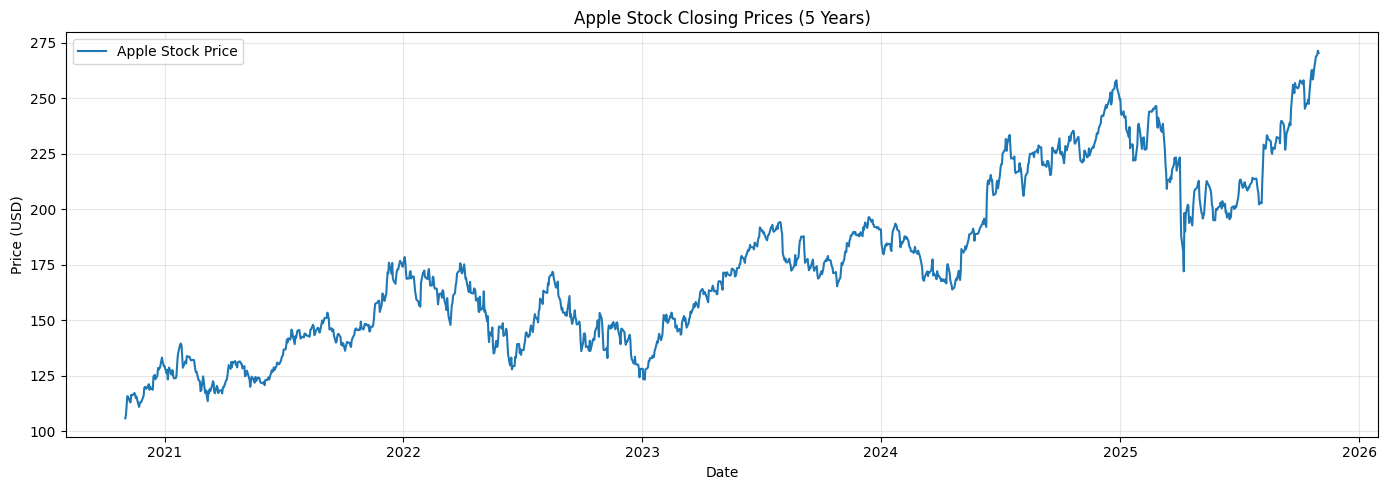

Data shape: (1305, 1)
Date range: 2020-11-02 00:00:00 to 2025-10-31 00:00:00
Price range: $105.80 to $271.40
Frequency: <BusinessDay>


In [25]:
# Load Apple stock data
apple_data = get_apple_5y()
apple_ts = apple_data['Close']

business_days = pd.date_range(start=apple_ts.index.min(), end=apple_ts.index.max(), freq='B')
apple_ts = apple_ts.reindex(business_days, method='ffill')

# Plot the data
plt.figure(figsize=(14, 5))
plt.plot(apple_ts.index, apple_ts.values, label='Apple Stock Price', linewidth=1.5)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Apple Stock Closing Prices (5 Years)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Data shape: {apple_ts.shape}")
print(f"Date range: {apple_ts.index.min()} to {apple_ts.index.max()}")
print(f"Price range: ${apple_ts.min().iloc[0]:.2f} to ${apple_ts.max().iloc[0]:.2f}")
print(f"Frequency: {apple_ts.index.freq}")


In [26]:
train_size_apple = int(len(apple_ts) * 0.8)
apple_train = apple_ts.iloc[:train_size_apple]
apple_test = apple_ts.iloc[train_size_apple:]

print(f"Training set: {len(apple_train)} observations")
print(f"Test set: {len(apple_test)} observations")

Training set: 1044 observations
Test set: 261 observations


### Compare ETS Models with Information Criteria and Residual Analysis

In [27]:
def evaluate_ets_model(model, train_data, test_data, model_name):
    """
    Fit an ETS model and evaluate with information criteria and residual analysis
    """
    # Fit the model
    model.fit(train_data)
    
    # Get fitted values and predictions
    fitted_values = model._fitted_forecaster.fittedvalues
    predictions = model.predict(fh=np.arange(1, len(test_data) + 1))
    
    # Calculate residuals
    residuals = train_data.values.flatten() - fitted_values.values.flatten()
    business_days = pd.date_range(start=train_data.index.min(), end=train_data.index.max(), freq='B')
    residuals = pd.Series(residuals, index=business_days)
    
    # Information criteria
    aic = model._fitted_forecaster.aic
    bic = model._fitted_forecaster.bic
    
    # Performance metrics
    mse_test = mean_squared_error(test_data, predictions)
    mae_test = mean_absolute_error(test_data, predictions)
    rmse_test = np.sqrt(mse_test)
    
    # Residual analysis
    residual_mean = residuals.mean()
    residual_std = residuals.std()
    
    return {
        'Model': model_name,
        'AIC': aic,
        'BIC': bic,
        'RMSE': rmse_test,
        'MAE': mae_test,
        'Residual Mean': residual_mean,
        'Residual Std': residual_std,
        'fitted': fitted_values,
        'predictions': predictions,
        'residuals': residuals
    }

In [28]:
apple_ets_models = {
    'ETS(A,N,N)': AutoETS(error='add', trend=None, seasonal=None, auto=False),
    'ETS(A,A,N)': AutoETS(error='add', trend='add', seasonal=None, auto=False),
    'ETS(A,Ad,N)': AutoETS(error='add', trend='add', damped_trend=True, seasonal=None, auto=False),
    'ETS(M,A,N)': AutoETS(error='mul', trend='add', seasonal=None, auto=False),
    'ETS(M,Ad,N)': AutoETS(error='mul', trend='add', damped_trend=True, seasonal=None, auto=False),
}

In [29]:
apple_ets_results = []
for name, model in apple_ets_models.items():
    result = evaluate_ets_model(model, apple_train, apple_test, name)
    apple_ets_results.append(result)
    print(f"{name} fitted successfully")

ETS(A,N,N) fitted successfully
ETS(A,A,N) fitted successfully
ETS(A,A,N) fitted successfully
ETS(A,Ad,N) fitted successfully
ETS(A,Ad,N) fitted successfully
ETS(M,A,N) fitted successfully
ETS(M,A,N) fitted successfully
ETS(M,Ad,N) fitted successfully
ETS(M,Ad,N) fitted successfully


In [30]:
apple_ets_df = pd.DataFrame([{k: v for k, v in r.items() if k not in ['fitted', 'predictions', 'residuals']} 
                              for r in apple_ets_results])
apple_ets_df = apple_ets_df.sort_values('AIC')
print("\n" + "="*80)
print("ETS Model Comparison for Apple Stock Prices")
print("="*80)
print(apple_ets_df.to_string(index=False))


ETS Model Comparison for Apple Stock Prices
      Model         AIC         BIC      RMSE       MAE  Residual Mean  Residual Std
 ETS(A,N,N) 4987.804264 5002.656709 20.152060 17.040331       0.114056      2.628783
 ETS(A,A,N) 4989.940989 5014.695063 25.646460 20.696020       0.000350      2.628911
ETS(A,Ad,N) 4991.022017 5020.726906 20.152205 17.040546       0.101413      2.625795
ETS(M,Ad,N) 5014.200306 5043.905195 20.150406 17.038039       0.101867      2.626033
 ETS(M,A,N) 5014.401513 5039.155587 30.227449 24.404030      -0.046015      2.629008


### Visualize All ETS Model Fits

Plot the fitted values and predictions for all Apple stock ETS models:

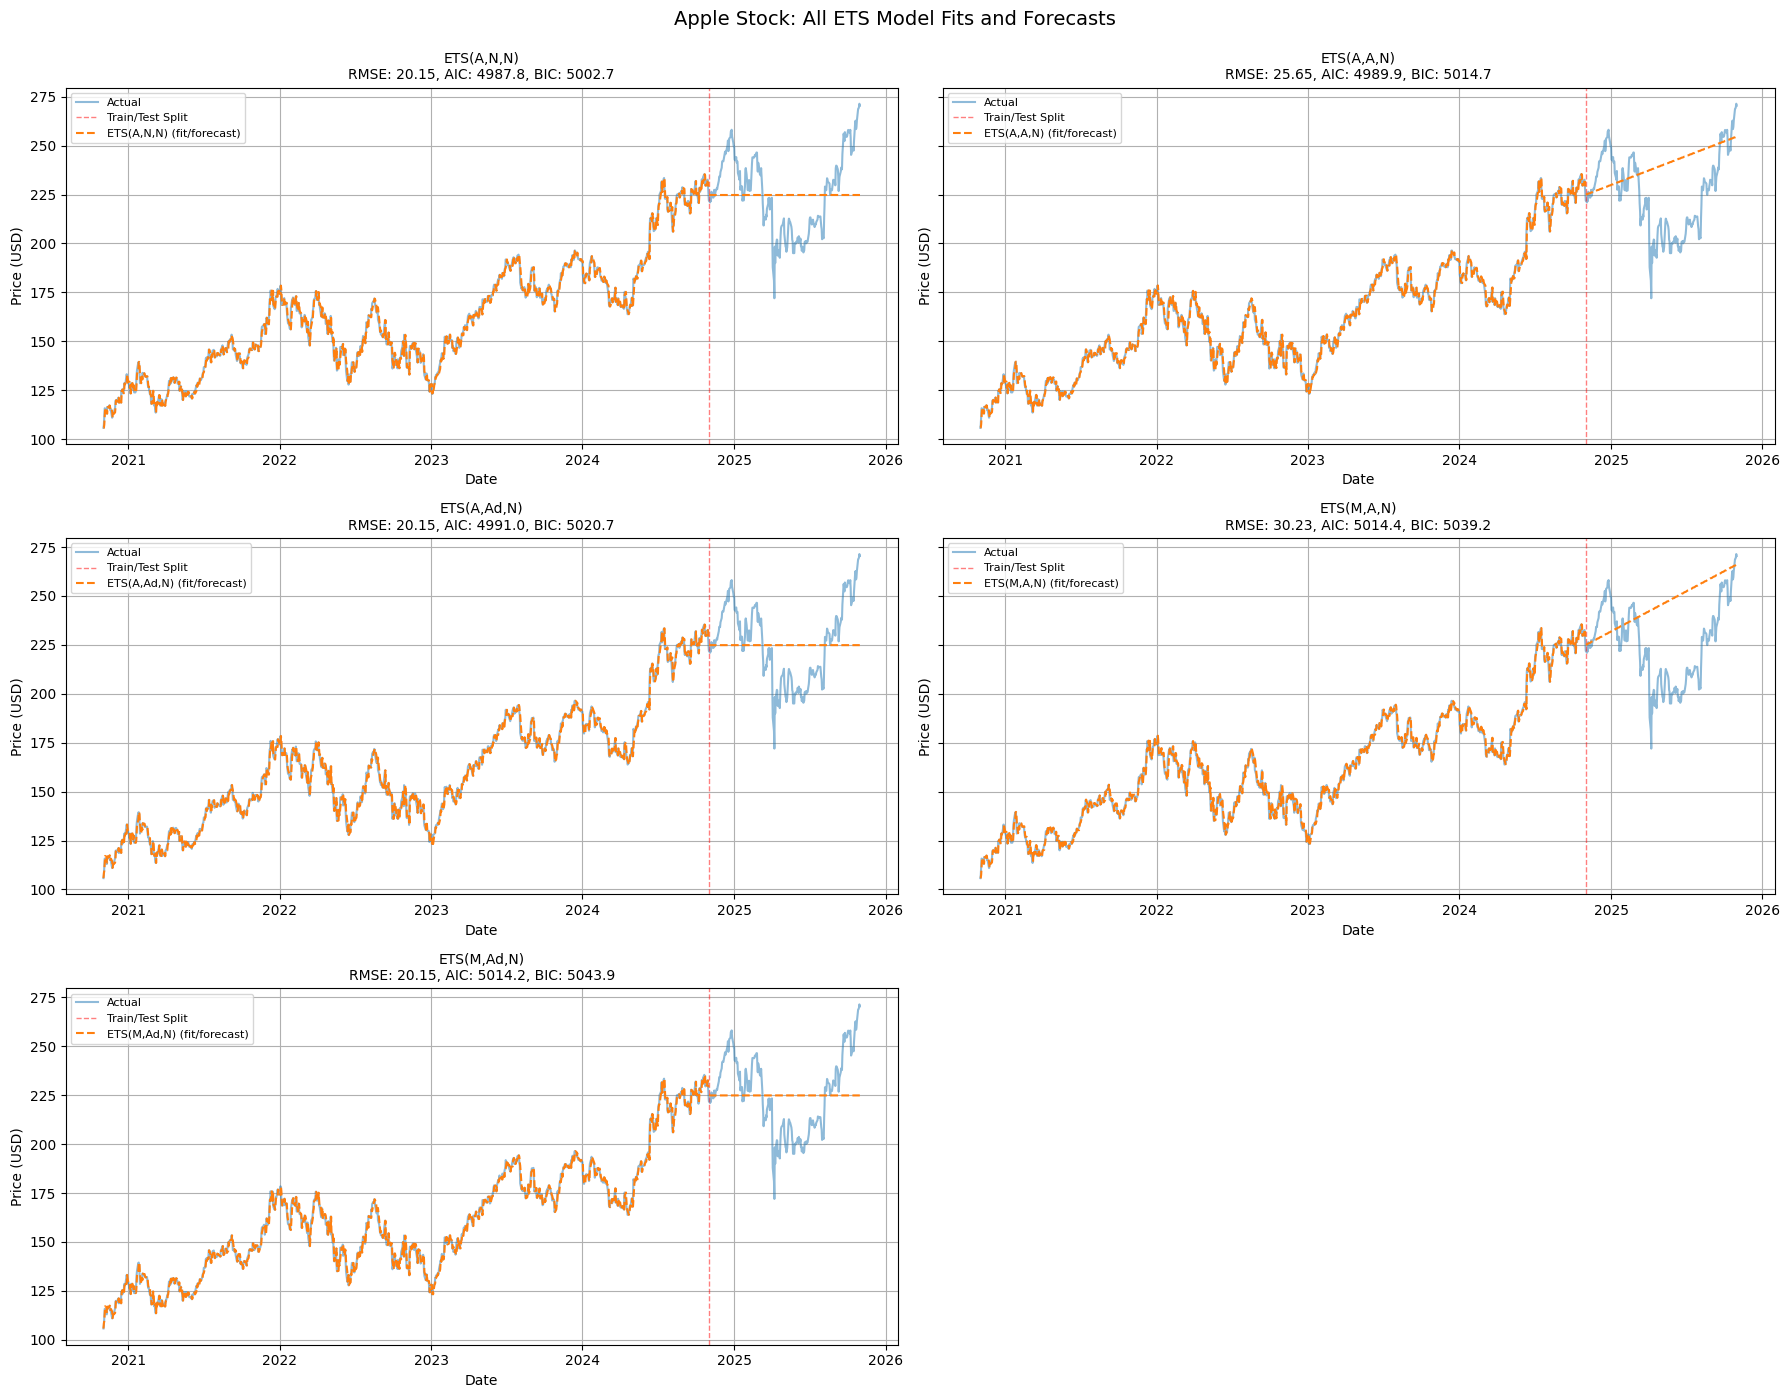


Model Performance Summary (sorted by RMSE):
ETS(M,Ad,N)     | RMSE:  20.15 | AIC:  5014.2 | BIC:  5043.9 | Res. Mean:  0.1019
ETS(A,N,N)      | RMSE:  20.15 | AIC:  4987.8 | BIC:  5002.7 | Res. Mean:  0.1141
ETS(A,Ad,N)     | RMSE:  20.15 | AIC:  4991.0 | BIC:  5020.7 | Res. Mean:  0.1014
ETS(A,A,N)      | RMSE:  25.65 | AIC:  4989.9 | BIC:  5014.7 | Res. Mean:  0.0004
ETS(M,A,N)      | RMSE:  30.23 | AIC:  5014.4 | BIC:  5039.2 | Res. Mean: -0.0460


In [31]:
# Plot all ETS model fits for Apple stock
fig, axs = get_figure(nrows=3, ncols=2, figsize=(18, 14), sharey=True)

for i, result in enumerate(apple_ets_results):
    ax = axs[i]
    
    # Plot actual data
    time_plot(x=apple_ts.index, y=apple_ts, label='Actual', ax=ax, alpha=0.5)
    
    # Plot train/test split line
    ax.axvline(x=apple_ts.index[train_size_apple], color='red', linestyle='--', 
              linewidth=1, alpha=0.5, label='Train/Test Split')
    
    # Plot fitted values and predictions
    plot_fit_and_forecast(ax, result['fitted'], result['predictions'], 
                         None, model_name=f"{result['Model']} (fit/forecast)")
    
    # Add performance metrics to title
    title = f"{result['Model']}\n"
    title += f"RMSE: {result['RMSE']:.2f}, AIC: {result['AIC']:.1f}, BIC: {result['BIC']:.1f}"
    ax.set_title(title, fontsize=10)
    ax.legend(fontsize=8, loc='upper left')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price (USD)')

# Turn off the last subplot if odd number of models
if len(apple_ets_results) < len(axs):
    axs[-1].axis('off')

fig.suptitle('Apple Stock: All ETS Model Fits and Forecasts', fontsize=14, y=0.995)
fig.tight_layout()
plt.show()

# Print summary
print("\nModel Performance Summary (sorted by RMSE):")
print("=" * 80)
for result in sorted(apple_ets_results, key=lambda x: x['RMSE']):
    print(f"{result['Model']:15s} | RMSE: {result['RMSE']:6.2f} | "
          f"AIC: {result['AIC']:7.1f} | BIC: {result['BIC']:7.1f} | "
          f"Res. Mean: {result['Residual Mean']:7.4f}")

Next the residual analysis:

In [32]:
def plot_residual_analysis(results_list, figsize=(16, 10)):
    """
    Plot comprehensive residual analysis for one or more models.
    
    Parameters:
    -----------
    results_list : list or dict
        Either a single dict from evaluate_ets_model() or a list of such dicts
        If you want to compare multiple models, pass a list
    figsize : tuple
        Figure size
        
    Returns:
    --------
    fig, axs : matplotlib figure and axes
    """
    from scipy import stats
    from statsmodels.stats.diagnostic import acorr_ljungbox
    
    # Handle single model case
    if isinstance(results_list, dict):
        results_list = [results_list]
    
    n_models = len(results_list)
    
    # Create subplots: 4 plots per model (residuals over time, histogram, ACF, Q-Q plot)
    fig, axs = plt.subplots(nrows=n_models, ncols=4, figsize=figsize)
    
    # Ensure axs is always 2D array
    if n_models == 1:
        axs = axs.reshape(1, -1)
    
    for i, result in enumerate(results_list):
        model_name = result['Model']
        residuals = result['residuals']
        
        # Row of axes for this model
        ax_row = axs[i]
        
        # 1. Residuals over time
        ax_row[0].plot(np.arange(len(residuals)), residuals)
        ax_row[0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
        ax_row[0].set_title(f"Residuals - {model_name}")
        ax_row[0].set_ylabel('Residual Value')
        ax_row[0].grid(True, alpha=0.3)
        
        # Add model stats as text
        stats_text = f"Mean: {result['Residual Mean']:.4f}\nStd: {result['Residual Std']:.4f}"
        stats_text += f"\nRMSE: {result['RMSE']:.2f}\nAIC: {result['AIC']:.1f}"
        ax_row[0].text(0.02, 0.98, stats_text, transform=ax_row[0].transAxes, 
                      verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5),
                      fontsize=8)
        
        # 2. Residual histogram with normal distribution overlay
        residuals_clean = residuals.dropna()
        ax_row[1].hist(residuals_clean, bins=30, density=True, edgecolor='black', alpha=0.7, label='Residuals')
        
        # Overlay normal distribution
        mu, std = residuals_clean.mean(), residuals_clean.std()
        xmin, xmax = ax_row[1].get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, mu, std)
        ax_row[1].plot(x, p, 'r-', linewidth=2, label=f'N({mu:.2f}, {std:.2f}²)')
        
        ax_row[1].set_title(f'Residual Distribution - {model_name}')
        ax_row[1].set_xlabel('Residual Value')
        ax_row[1].set_ylabel('Density')
        ax_row[1].legend(fontsize=8)
        ax_row[1].grid(True, alpha=0.3)
        
        # 3. ACF of residuals
        acf_plot(residuals_clean, nlags=min(40, len(residuals_clean)//2), ax=ax_row[2])
        ax_row[2].set_title(f'ACF - {model_name}')
        
        # Ljung-Box test
        try:
            lb_test = acorr_ljungbox(residuals_clean, lags=[10], return_df=True)
            lb_pvalue = lb_test['lb_pvalue'].iloc[0]
            ax_row[2].text(0.02, 0.98, f'Ljung-Box p={lb_pvalue:.4f}', 
                          transform=ax_row[2].transAxes, 
                          verticalalignment='top',
                          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                          fontsize=8)
        except:
            pass
        
        # 4. Q-Q plot
        stats.probplot(residuals_clean, dist="norm", plot=ax_row[3])
        ax_row[3].set_title(f'Q-Q Plot - {model_name}')
        ax_row[3].grid(True, alpha=0.3)
    
    fig.suptitle('Residual Analysis Comparison', fontsize=14, y=0.995)
    fig.tight_layout()
    
    return fig, axs

Compare residuals for top 3 models, based on the AIC.

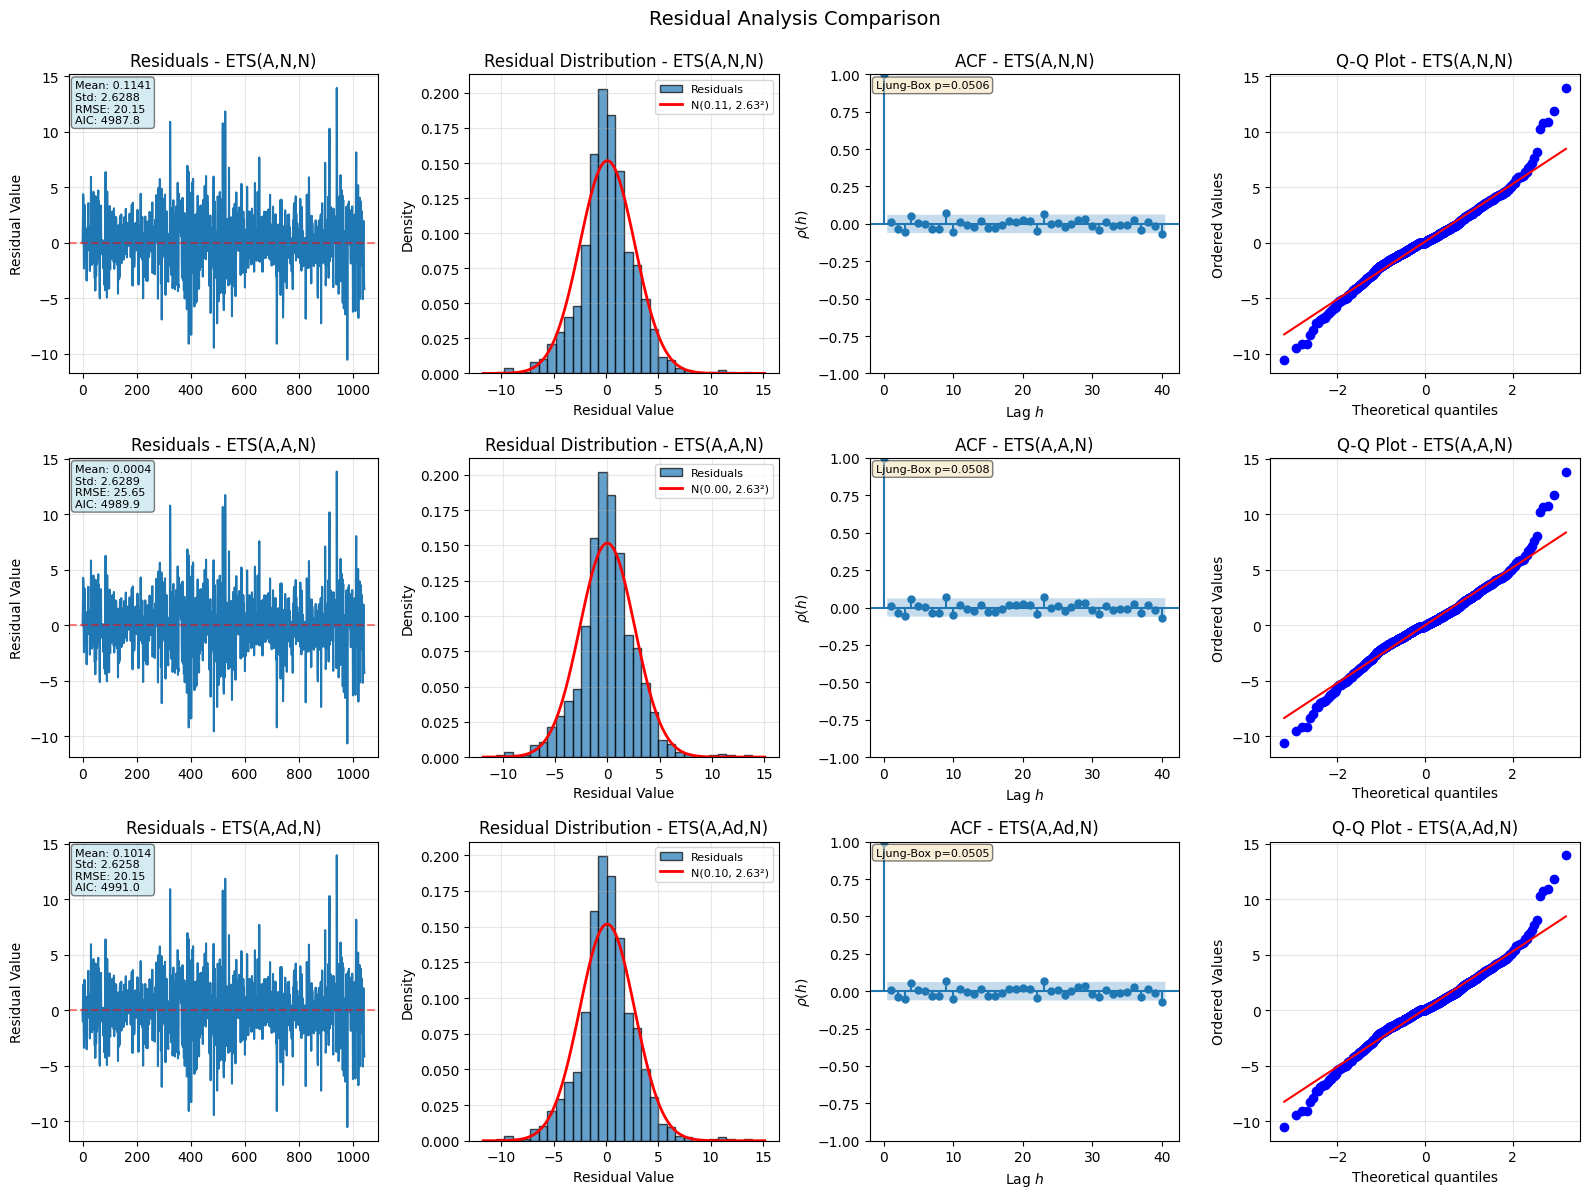

In [33]:
# Compare top 3 models based on RMSE
top_3_models = sorted(apple_ets_results, key=lambda x: x['AIC'])[:3]

plot_residual_analysis(top_3_models, figsize=(16, 12))
plt.show()

The residuals of the three best ETS models are very similar and all show a normal-like distribution. From these I would actually choose the ETS(A,A, N) due to it's lower AIC and BIC score than the ETS(A, Ad, N) model.

In [34]:
apple_ets_model = top_3_models[1]

### Compare with ARIMA Models using Cross-Validation

In [35]:
from sktime.forecasting.model_selection import ExpandingWindowSplitter

def cross_validate_model(model, data, n_splits=5, test_size=50):
    """
    Perform time series cross-validation
    """
    cv = ExpandingWindowSplitter(initial_window=len(data) - test_size * n_splits, 
                                fh=np.arange(1, test_size+1), 
                                step_length=test_size)
    
    scores = []
    for train_idx, test_idx in cv.split(data):
        train_data = data.iloc[train_idx]
        test_data = data.iloc[test_idx]
        
        try:
            model_clone = model.clone()
            model_clone.fit(train_data)
            predictions = model_clone.predict(fh=np.arange(1, len(test_data) + 1))
            
            mse = mean_squared_error(test_data, predictions)
            mae = mean_absolute_error(test_data, predictions)
            
            scores.append({'MSE': mse, 'MAE': mae, 'RMSE': np.sqrt(mse)})
        except Exception as e:
            print(f"Error in fold: {e}")
            continue
    
    if scores:
        return pd.DataFrame(scores)
    return None

In [36]:
# Compare best ETS with equivalent ARIMA models
models_to_compare = {
    'ETS(A,A,N)': AutoETS(error='add', trend='add', damped_trend=False, seasonal=None, auto=False),
    'ARIMA(0,2,2)': ARIMA(order=(0,2,2))
}

cv_results = {}
for name, model in models_to_compare.items():
    print(f"Cross-validating {name}...")
    scores = cross_validate_model(model, apple_ts, n_splits=5, test_size=50)
    if scores is not None:
        cv_results[name] = scores
        print(f"  Mean RMSE: {scores['RMSE'].mean():.2f} ± {scores['RMSE'].std():.2f}")

# Compare CV results
cv_summary = pd.DataFrame({
    name: {
        'Mean RMSE': scores['RMSE'].mean(),
        'Std RMSE': scores['RMSE'].std(),
        'Mean MAE': scores['MAE'].mean(),
        'Std MAE': scores['MAE'].std()
    }
    for name, scores in cv_results.items()
}).T


print(cv_summary)

Cross-validating ETS(A,A,N)...


  Mean RMSE: 16.66 ± 3.12
Cross-validating ARIMA(0,2,2)...


c:\Users\kybur\Repos\HSLU\time\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  Mean RMSE: 18.01 ± 3.10
              Mean RMSE  Std RMSE   Mean MAE   Std MAE
ETS(A,A,N)    16.659800  3.124885  14.286077  2.412703
ARIMA(0,2,2)  18.007039  3.104853  15.616223  2.488287


From this initial comparison it looks like the ETS model is performing better.

### Compare Prediction Intervals

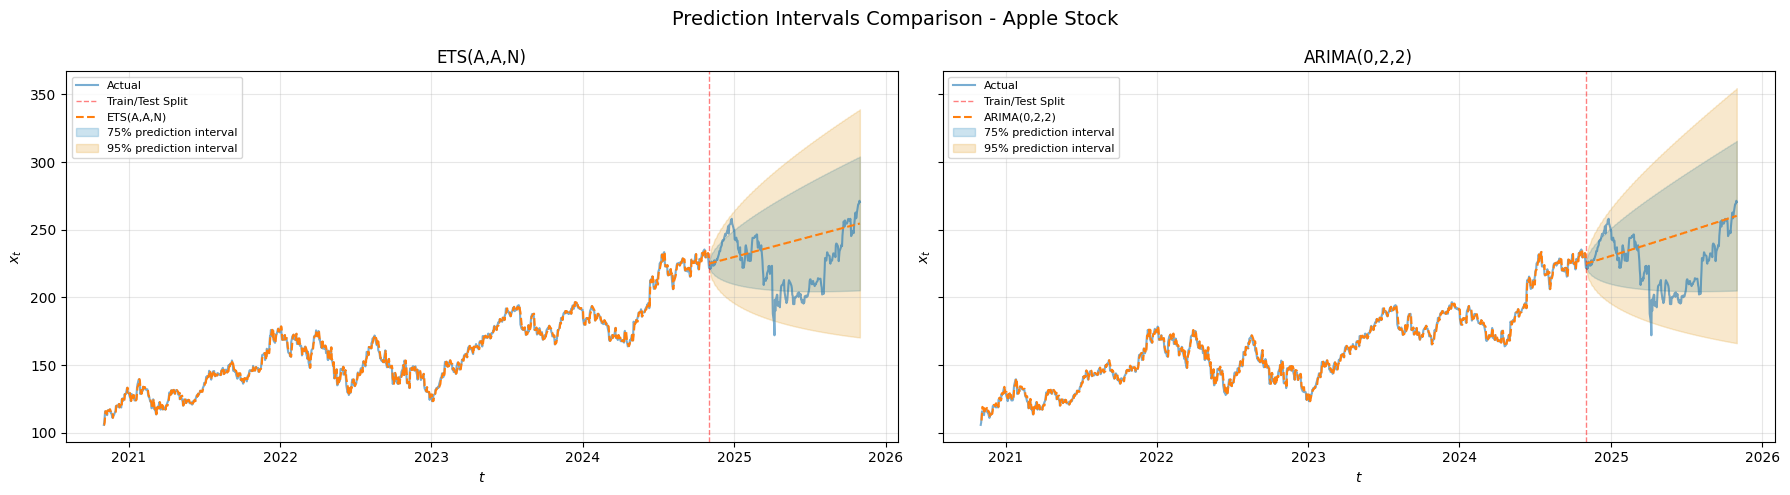

In [37]:
# Fit models and get prediction intervals
fig, axs = get_figure(nrows=1, ncols=2, figsize=(18, 5), sharey=True)

for i, (name, model) in enumerate(models_to_compare.items()):
    ax = axs[i]
    
    # Fit and forecast
    fitted_vals, predictions, pred_interval = fit_and_forecast(model, apple_ts, train_size_apple)
    
    # Plot actual data
    time_plot(x=apple_ts.index, y=apple_ts, label='Actual', ax=ax, alpha=0.6)
    ax.axvline(x=apple_ts.index[train_size_apple], color='red', linestyle='--', 
              linewidth=1, alpha=0.5, label='Train/Test Split')
    
    # Plot fitted and forecast
    plot_fit_and_forecast(ax, fitted_vals, predictions, pred_interval, model_name=name)
    
    ax.set_title(f'{name}')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

fig.suptitle('Prediction Intervals Comparison - Apple Stock', fontsize=14)
fig.tight_layout()
plt.show()

The confidence interval of the ETS model is slightly narrower, meaning that it has more confidence ion it's predictions/more of the predictions will fall closer to the forecase, than in the ARIMA model.

### Compare ETS Components with STL Decomposition

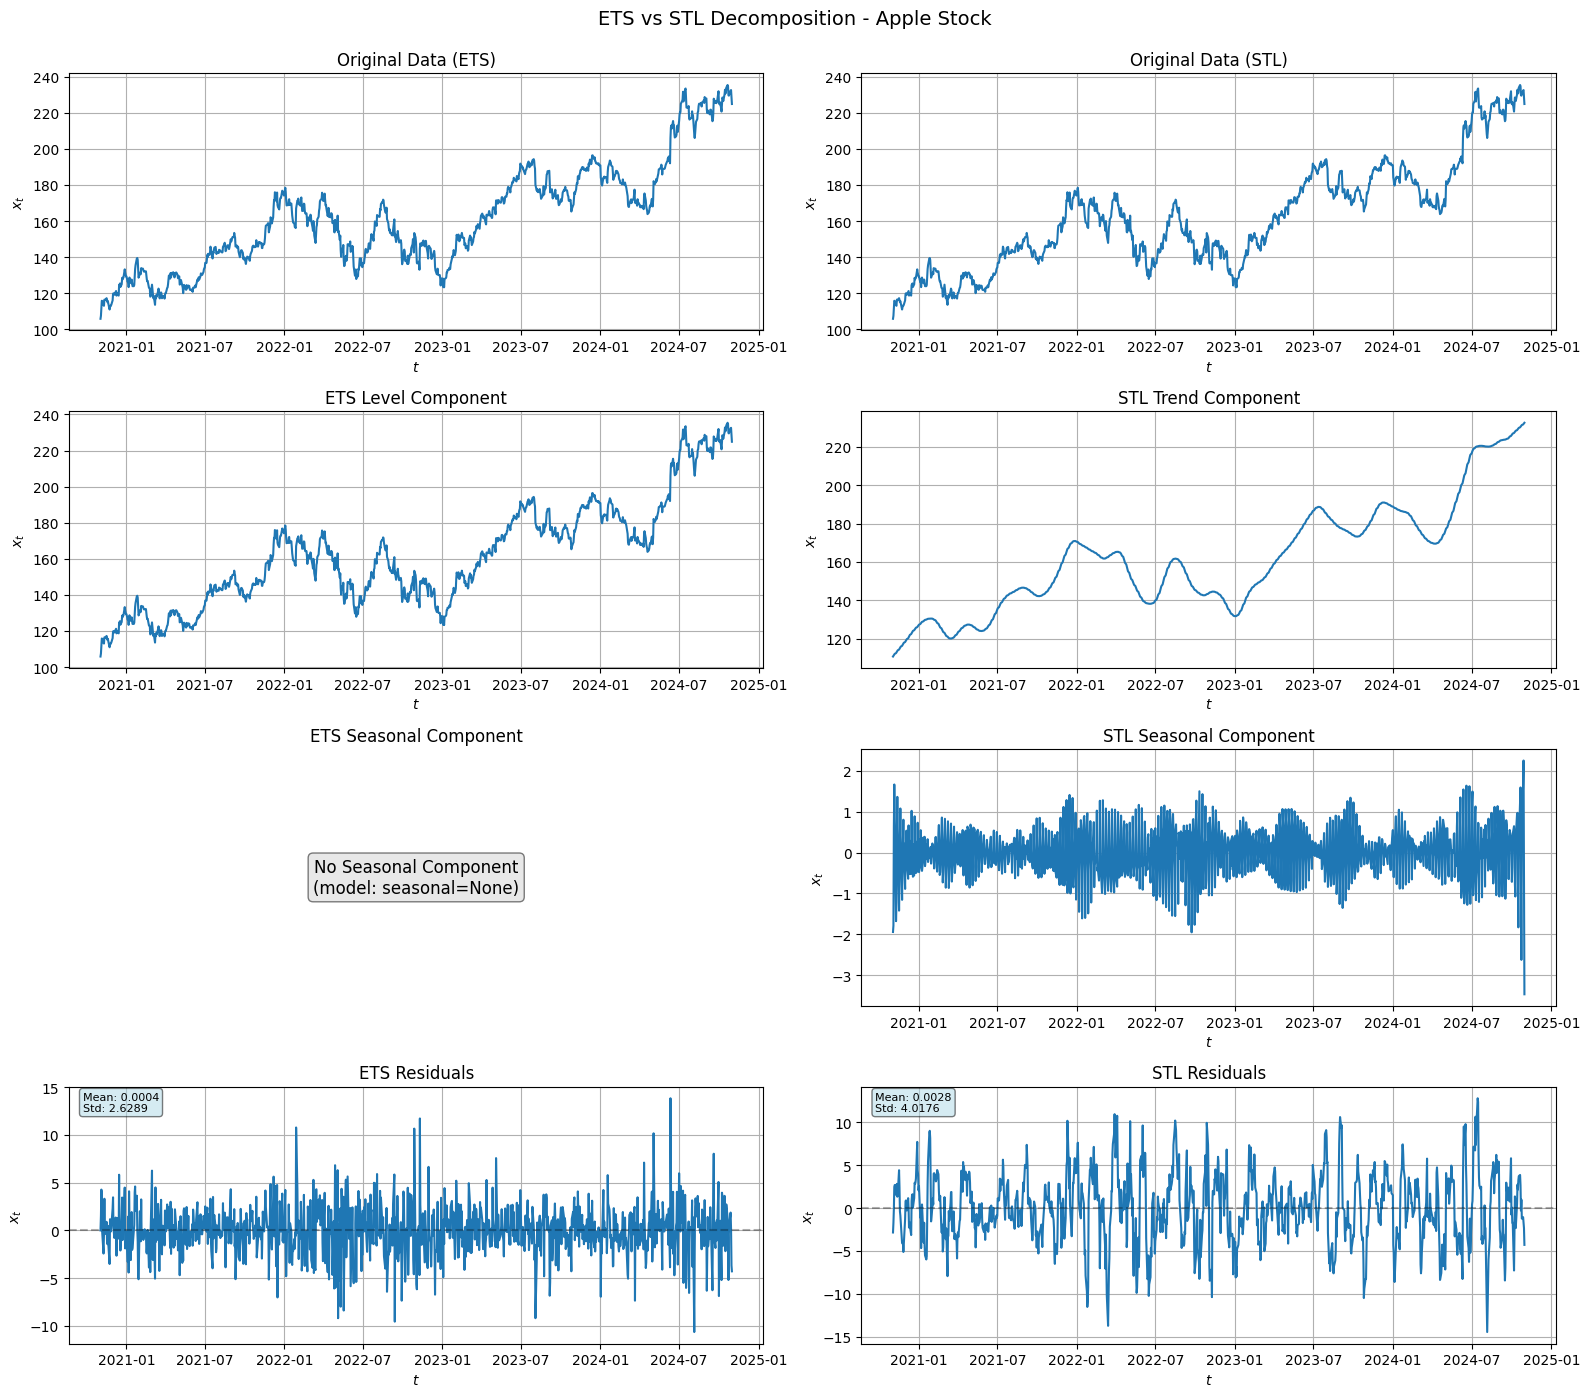

In [38]:

# Fit ETS model with trend
ets_model = AutoETS(error='add', trend="add", damped_trend=False, seasonal=None, auto=False)
ets_model.fit(apple_train)

# Extract ETS components
ets_level = ets_model._fitted_forecaster.level
ets_trend = ets_model._fitted_forecaster.slope
ets_fitted = ets_model._fitted_forecaster.fittedvalues
ets_residuals = apple_train.values.flatten() - ets_fitted.values.flatten()
business_days = pd.date_range(start=apple_train.index.min(), end=apple_train.index.max(), freq='B')
ets_residuals = pd.Series(ets_residuals, index=business_days)

# Check if ETS has seasonal component (it shouldn't for this model)
ets_seasonal = None
if hasattr(ets_model._fitted_forecaster, 'season'):
    ets_seasonal = ets_model._fitted_forecaster.season

# Perform STL decomposition (using a large period since no clear seasonality)
stl = STL(apple_train, seasonal=13, trend=51)  # Using arbitrary period
stl_result = stl.fit()

# Compare components side-by-side
fig, axs = get_figure(nrows=4, ncols=2, figsize=(16, 14))

# Row 0: Original data
time_plot(x=apple_train.index, y=apple_train, title='Original Data (ETS)', ax=axs[0])
time_plot(x=apple_train.index, y=apple_train, title='Original Data (STL)', ax=axs[1])

# Row 1: Level/Trend comparison
time_plot(x=apple_train.index, y=ets_level, title='ETS Level Component', ax=axs[2])
time_plot(x=apple_train.index, y=stl_result.trend, title='STL Trend Component', ax=axs[3])

# Row 2: Seasonal comparison
axs[4].text(0.5, 0.5, 'No Seasonal Component\n(model: seasonal=None)', 
           ha='center', va='center', fontsize=12, 
           bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))
axs[4].set_title('ETS Seasonal Component')
axs[4].axis('off')
time_plot(x=apple_train.index, y=stl_result.seasonal, title='STL Seasonal Component', ax=axs[5])

# Row 3: Residuals comparison
time_plot(x=ets_residuals.index, y=ets_residuals, title='ETS Residuals', ax=axs[6])
axs[6].axhline(y=0, color='black', linestyle='--', alpha=0.3)
ets_res_stats = f'Mean: {ets_residuals.mean():.4f}\nStd: {ets_residuals.std():.4f}'
axs[6].text(0.02, 0.98, ets_res_stats, transform=axs[6].transAxes, 
           verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5),
           fontsize=8)

time_plot(x=apple_train.index, y=stl_result.resid, title='STL Residuals', ax=axs[7])
axs[7].axhline(y=0, color='black', linestyle='--', alpha=0.3)
stl_res_stats = f'Mean: {stl_result.resid.mean():.4f}\nStd: {stl_result.resid.std():.4f}'
axs[7].text(0.02, 0.98, stl_res_stats, transform=axs[7].transAxes, 
           verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5),
           fontsize=8)

fig.suptitle('ETS vs STL Decomposition - Apple Stock', fontsize=14, y=0.995)
fig.tight_layout()
plt.show()

ETS Level vs STL Trend: ETS is more responsive to changes while STL provides a smoother, long-term view. The residuals of the ETS have a smaller standard deviation, indicating better model fit (potential overfit however).